In [34]:
# multistep(7days) ahead forecasting
# 추석연휴 피쳐 변경 & 범주형 데이터는 스케일링 제외 2022.05.25

In [52]:
# Ignore the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from itertools import product # iterative combinations
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

# Keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout
from keras.layers import SimpleRNN, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [53]:
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred) # 아래 evaluation_trte를 보면 실제Y값(Y_real)을 데이터프레임으로 입력받았기 때문에 다시 array로 변환하고 flatten함, 예측Y값(Y_pred)은 array를 flatten한 값으로 입력받기때문에 추가변환 없음     
    if loss_length != 0:                                     # 잔차값 array길이가 0이 아니면 실제Y값을 길이를 줄여준다. 하지만 왜 앞에서부터 짜르지?
        Y_real = Y_real[loss_length:]                        
    if graph_on == True:                                     
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6), # 실제Y값(Y_real)은 flattenee된 array이니까 다시 데이터프레임으로 변환하고 실제값(Y_real)의 index과 동일하게 indexing하고 concat한다.
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)


### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

In [54]:
# Data Loading
cvd19   = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/cvd19_ox_0513.csv')   # 코로나
wth     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/wth_0513.csv')     # 기상 & 관광입도객(제주관광협회)
psg     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv//0513/psg_0513.csv')     # 공합입도객수
sch     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/0513/search_0513.csv')     # 검색량

#rnt     = pd.read_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/rnt.csv')     # 렌트카
#cpt_prc = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/cpt_prc.csv') # 경쟁사 가격
#mk_sr   = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/mk_sr.csv')   # 시장점유율
#air_tck = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/air_tck.csv') # 예매 가능한 비행티켓(인터파크)
#prm     = pd.read_csv('/Users/kimjinseok/Desktop/kaflix_demand forecasting/csv/prm.csv')     # 프로모션

# Datetime 
cvd19['date']=pd.to_datetime(cvd19['date'])
wth['DT']=pd.to_datetime(wth['DT'])
psg['DT']=pd.to_datetime(psg['DT'])
sch['period']=pd.to_datetime(sch['period'])
cvd19=cvd19[cvd19['location']=='South Korea']

# psg   : 2019-05-01 ~ 2022-04-28 제주공항 입도객수
# cvd19 : 2020-01-22 ~ 2022-05-12 코로나 거리두기 정책지수
# sch   : 2019-05-14 ~ 2022-05-13 '제주렌트카' 검색량
# wth   : 2017-01-01 ~ 2022-12-25 날씨 및 공휴일
# 모두 겹치는 일정 2019-05-14(코로나 제외) ~ 2022-04-28

# psg에 모든 주에 데이터 있는지 검증 => 20190-05-01부터 2022-04-28까지는 1094일
#len(psg['DT'].unique()) 

# Indexing pgs date & left join with other data
psg = psg.sort_values("DT")
psg.set_index("DT", inplace=True)
psg = psg.loc[psg.index >= '2019-05-14',:]  # 0513까지 삭제
psg = psg.groupby("DT")['ARRIVE_PPL'].sum() # 일별 입도객 합계
psg = pd.DataFrame(psg)                     # 데이터프레임만들고
cvd19.rename(columns={'date':'DT'}, inplace=True)
sch.rename(columns={'period':'DT'}, inplace=True)

# Select Required Data
cvd19 = cvd19[['DT', 'stringency_index', 'new_tests_per_thousand', 'total_vaccinations_per_hundred', 'total_boosters_per_hundred']] 
wth = wth[['DT','TEMPERTURE','RAIN','HOLIDAY_NAME']]

# merge psg & cvd19
merged = pd.merge(psg, cvd19, on="DT", how="left")

# holiday preprocessing for long and interspersed
wth_h = wth[['DT', 'HOLIDAY_NAME']]

# 1 for 'Lunar New Years' and 'Chuseok' & other holidays 
#wth_h['wth_m']=np.where((wth_h['HOLIDAY_NAME']=='설날') | (wth_h['HOLIDAY_NAME']=='추석'), 1, 0)
wth_h.HOLIDAY_NAME.loc[~wth_h.HOLIDAY_NAME.isnull()] = 1
wth_h = wth_h.sort_values('DT')
wth_h.HOLIDAY_NAME.loc[wth_h.HOLIDAY_NAME.isnull()] = 0
#wth_h['HOLIDAY_NAME']=wth_h['HOLIDAY_NAME'] + wth_h['wth_m']
wth_h.HOLIDAY_NAME.unique()

array([1, 0], dtype=object)

In [55]:
# [long holidays] and [Holidays Interspersed with Workdays]
wth_h['dayofweek'] = wth_h.DT.dt.dayofweek

# 공휴일인데 금요일(4)이면 그주 금요일(4)을 연휴시작으로
# 공휴일인데 월요일(0)이면 전주 토요일(5)을 연휴시작으로
wth_h['flong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 4), 1, 0)
wth_h['mlong']=np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 0), 1, 0)

#월요일 연휴는 그 전 토요일에 연휴 시작 표시
wth_h['mlong']= wth_h['mlong'].shift(-2)
wth_h['mlong'].fillna(method='ffill', inplace = True)

#금요일 연휴, 월요일 연휴 컬럼 합치기
wth_h['long_h']=wth_h['flong'] + wth_h['mlong'] 

#연휴시작 하루 전날 표시
wth_h['b_long_h']=wth_h['long_h'].shift(-1)
wth_h['b_long_h'].fillna(method='ffill', inplace = True)

# 징검다리 로직
# 휴일인데 목요일(3)이면 그주 목요일(3)을 징검다리 연휴시작
# 휴일인데 화요일(1)이면 전주 토요일(5)을 징검다리 연휴시작
wth_h['thinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 3), 1, 0)
wth_h['tuinter'] = np.where((wth_h['HOLIDAY_NAME'] == 1) & (wth_h['dayofweek'] == 1), 1, 0)

# 화요일 징검다리는 전주 토요일에 연휴 시작 표시
wth_h['tuinter'] = wth_h['tuinter'].shift(-3)
wth_h['tuinter'].fillna(method='ffill', inplace = True)
wth_h['inter_h'] = wth_h['thinter'] + wth_h['tuinter'] 

# 징검다리 시작 하루 전날 표시
wth_h['b_inter_h'] = wth_h['inter_h'].shift(-1)
wth_h['b_inter_h'].fillna(method='ffill', inplace = True)


In [56]:
# [first day of myeojeol] 
#holiday    : 설날/추석 명절 -> 1
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#b_first_m  : 설날/추석 명절연휴 시작일 전날, 단 명절 연휴시작이 (일) 또는 (월)이면 (금)이 시작일 전날 -> 1로 표시b

In [57]:
#first_m    : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일) 또는 (월)이면 (토)가 시작일 -> 1 표시
#2017-01-27, 2017-10-03, 2018-02-15, 2018-09-23, 2019-02-04, 2019-09-12, 2020-01-24, 2020-09-30, 2021-02-11, 2021-09-30, 2022-02-01

#first_m_nosm   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (화) 또는 (수) 또는 (목) 또는 (금) 또는 (토) 이면 1
wth_h['first_m_nosm']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & ((wth_h['dayofweek'] != 6) & (wth_h['dayofweek'] !=0)), 1,0)

#first_m_s   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (일)이면 1로 표시하고 shift -1
wth_h['first_m_s']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 6), 1,0)
wth_h['first_m_s'] = wth_h['first_m_s'].shift(-1)
wth_h['first_m_s'].fillna(method='ffill', inplace = True)

#first_m_m   : 설날/추석 명절연휴 시작일,단 명절 연휴시작이 (월)이면 1로 표시하고 shift -2
wth_h['first_m_m']=np.where(((wth_h['DT'] == '2017-01-27') |
                          (wth_h['DT'] == '2017-10-03') |
                          (wth_h['DT'] == '2018-02-15') |
                          (wth_h['DT'] == '2018-09-23') |
                          (wth_h['DT'] == '2019-02-04') |
                          (wth_h['DT'] == '2019-09-12') |
                          (wth_h['DT'] == '2020-01-24') |
                          (wth_h['DT'] == '2020-09-30') |
                          (wth_h['DT'] == '2021-02-11') |
                          (wth_h['DT'] == '2021-09-20') |
                          (wth_h['DT'] == '2022-01-31') )
                          & (wth_h['dayofweek'] == 0), 1,0)
wth_h['first_m_m'] = wth_h['first_m_m'].shift(-2)
wth_h['first_m_m'].fillna(method='ffill', inplace = True)

wth_h['first_m'] = wth_h['first_m_nosm'] + wth_h['first_m_s'] + wth_h['first_m_m']

wth_h['b_first_m'] = wth_h['first_m'].shift(-1)
wth_h['b_first_m'].fillna(method='ffill', inplace=True)


In [58]:
wth_h.columns

Index(['DT', 'HOLIDAY_NAME', 'dayofweek', 'flong', 'mlong', 'long_h',
       'b_long_h', 'thinter', 'tuinter', 'inter_h', 'b_inter_h',
       'first_m_nosm', 'first_m_s', 'first_m_m', 'first_m', 'b_first_m'],
      dtype='object')

In [59]:
wth_h.drop(['flong', 'mlong', 'thinter','tuinter', 'first_m_nosm','first_m_s', 'first_m_m'], axis=1, inplace=True)

In [60]:
# merge wether & searching data 
wth=wth[['DT','TEMPERTURE','RAIN']]
wth=pd.merge(wth, wth_h, how='left', on='DT')
merged=pd.merge(merged, wth, on="DT", how="left")
merged=pd.merge(merged, sch, on='DT', how='left')
merged


# columns rename
merged.columns = ['datetime' , 'count', 'cvd_index', 'new_test', 'total_vaccin', 'total_booster' ,'temperature', 'rain', 'holiday', 'dayofweek','long_h','b_long_h','inter_h','b_inter_h','first_m','b_first_m','search']

# nan to zero
cvd_cols = ['cvd_index', 'new_test', 'total_vaccin', 'total_booster']
merged[cvd_cols] = merged[cvd_cols].replace({np.nan:0})

In [61]:
# feature engineering for time-series
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)

    # decompose trend / seasonal data 
    decompose=sm.tsa.seasonal_decompose(raw['count'], model='additive')
    decompose.plot()

    # add trend data 
    Y_trend=pd.DataFrame(decompose.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns=['count_trend']
    raw = pd.concat([raw, Y_trend], axis=1)
    
    # add seasonal data 
    Y_seasonal = pd.DataFrame(decompose.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns=['count_seasonal']
    raw = pd.concat([raw, Y_seasonal], axis=1)
    
    # add weekly data 
    Y_count_Week = raw[['count']].rolling(7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns=['count_Week']
    raw = pd.concat([raw, Y_count_Week], axis=1)
    
    # add difference data 
    Y_diff = raw[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    raw = pd.concat([raw, Y_diff], axis=1)

    # add time series data 
    raw['year']       = raw.datetime.dt.year
    raw['quarter']    = raw.datetime.dt.quarter
    raw['month']      = raw.datetime.dt.month
    raw['count_lag1'] = raw['count']#.shift(1)
    #raw['count_lag1'].fillna(method = 'bfill', inplace=True)
    raw['count_lag2'] = raw['count']#.shift(2)
    #raw['count_lag2'].fillna(method = 'bfill', inplace=True)


    # dummy 변수(카테고리 변수) => holiday(0,1) / dayofweek(0,1,2,3,4,5,6) / long_h(0,1) / b_long_h(0,1) / inter_h(0,1) / b_inter_h(0,1) 
    #                         /first_m(0,1)/ b_first_m(0,1) / year(2019,2020,2021,2022) / month(1~12) / quarter(1~4)

    raw = pd.concat([raw, pd.get_dummies(raw['holiday'],   prefix='holiday'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['dayofweek'], prefix='dayofweek' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['long_h'],    prefix='long_h'    + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_long_h'],  prefix='b_long_h'  + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['inter_h'],   prefix='inter_h'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_inter_h'], prefix='b_inter_h' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['first_m'],   prefix='first_m'   + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['b_first_m'], prefix='b_first_m' + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['year'],      prefix='year'      + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['month'],     prefix='month'     + '_dummy')], axis=1)
    raw = pd.concat([raw, pd.get_dummies(raw['quarter'],   prefix='quarter'   + '_dummy')], axis=1)

    raw = raw.drop(columns=['holiday', 'dayofweek', 'long_h', 'b_long_h', 'inter_h', 'b_inter_h','first_m','b_first_m', 'year', 'month', 'quarter'])
    
    raw_fe = raw.copy() 
    return raw_fe

# Reality _ feature_engineering_year_duplicated
# target = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
def feature_engineering_year_duplicated(raw, target):
    raw_feRD = raw.copy()
    for col in target:
        raw_feRD.loc['2021-04-29':'2022-04-28', col] = raw_feRD.loc['2020-04-29':'2021-04-28', col].values
    return raw_feRD

# Data Split for time series to train & test
def datasplit_ts(raw, criteria):
    raw_train = raw.loc[merged.index < criteria, :]
    raw_test  = raw.loc[merged.index >= criteria, :]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    return raw_train, raw_test

# Y_colname = ['count']
# X_remove = ['datetime', 'DateTime']
# X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split for Y_train, X_train
def datasplit_train(train, Y_colname, X_colname):
    X_colname = [x for x in train.columns if x not in Y_colname + X_remove]
    Y_train = train[Y_colname]
    X_train = train[X_colname]
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    return X_train, Y_train

# Data Split for Y_train, X_train
def datasplit_test(test, Y_colname, X_colname):
    X_colname = [x for x in test.columns if x not in Y_colname + X_remove]
    Y_test = test[Y_colname]
    X_test = test[X_colname]
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_test, Y_test


# modify lagged values of X_test
# target = ['count_lag1', 'count_lag2']
def feature_engineering_lag_modified(Y, X, target):
    X_lm = X.copy()
    i = 1
    for col in target:
        X_lm[col] = Y.shift(i).values
        X_lm[col].fillna(method='bfill', inplace=True)
        i = i + 1
    return X_lm

Train_size: (1021, 56) Test_size: (60, 56)
X_train: (1021, 54) Y_train: (1021, 1)
X_test: (60, 54) Y_test: (60, 1)


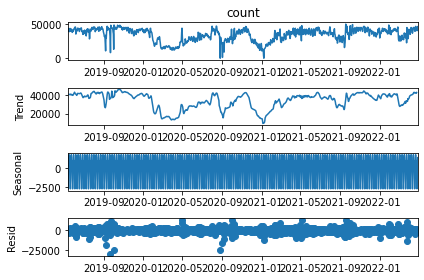

In [62]:
# Feature Engineering
merged_fe  = feature_engineering(merged)

# Reality _ feature_engineering_year_duplicated
target_d  = ['count_trend', 'count_seasonal', 'count_Week', 'count_diff']
merged_feRD = feature_engineering_year_duplicated(merged_fe, target_d)

# Data Split for time series to train & test
Train, Test = datasplit_ts(merged_feRD, '2022-02-28')

Y_colname = ['count']
X_remove = ['datetime', 'DateTime']
X_colname = [x for x in merged.columns if x not in Y_colname + X_remove]

# Data Split to X and Y
X_train, Y_train = datasplit_train(Train,Y_colname, X_colname)
X_test, Y_test = datasplit_test(Test,Y_colname, X_colname)

# Reality _ modify lagged values of X_train
target_l = ['count_lag1', 'count_lag2']
X_train = feature_engineering_lag_modified(Y_train, X_train, target_l)

# Reality _ modify lagged values of X_test
target_l = ['count_lag1', 'count_lag2']
X_test = feature_engineering_lag_modified(Y_test, X_test, target_l)


In [63]:
continous_feature=['cvd_index', 'new_test', 'total_vaccin', 'total_booster', 'temperature',
                   'rain', 'search', 'count_trend', 'count_seasonal', 'count_Week',
                   'count_diff', 'count_lag1', 'count_lag2']

category_feature=['holiday_dummy_0','holiday_dummy_1', 'dayofweek_dummy_0',
                  'dayofweek_dummy_1', 'dayofweek_dummy_2', 'dayofweek_dummy_3','dayofweek_dummy_4',
                  'dayofweek_dummy_5', 'dayofweek_dummy_6','long_h_dummy_0.0', 'long_h_dummy_1.0',
                  'b_long_h_dummy_0.0','b_long_h_dummy_1.0', 'inter_h_dummy_0.0', 'inter_h_dummy_1.0',
                  'b_inter_h_dummy_0.0', 'b_inter_h_dummy_1.0', 'first_m_dummy_0.0', 'first_m_dummy_1.0',
                  'b_first_m_dummy_0.0', 'b_first_m_dummy_1.0', 'year_dummy_2019', 'year_dummy_2020', 
                  'year_dummy_2021','year_dummy_2022', 'month_dummy_1', 'month_dummy_2', 'month_dummy_3',
                  'month_dummy_4', 'month_dummy_5', 'month_dummy_6', 'month_dummy_7','month_dummy_8',
                  'month_dummy_9', 'month_dummy_10', 'month_dummy_11','month_dummy_12', 'quarter_dummy_1', 
                  'quarter_dummy_2','quarter_dummy_3', 'quarter_dummy_4']

In [65]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
n_steps_in = 24
n_steps_out = 7
epoch = 40
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_con = scaler_X_tr.fit_transform(X_train[continous_feature])
X_train_cat = X_train[category_feature].to_numpy()
X_train_lstm = np.concatenate((X_train_con, X_train_cat), axis=1)
Y_train_lstm = scaler_Y_tr.fit_transform(Y_train)

X_test_con = scaler_X_tr.transform(X_test[continous_feature])
X_test_cat = X_test[category_feature].to_numpy()
X_test_lstm = np.concatenate((X_test_con, X_test_cat), axis=1)
Y_test_lstm = scaler_Y_tr.transform(Y_test)

In [66]:
print('X_train_lstm:', X_train_lstm.shape, 'Y_train_lstm:', Y_train_lstm.shape)
print('X_test_lstm:', X_test_lstm.shape, 'Y_test_lstm:', Y_test_lstm.shape)

X_train_lstm: (1021, 54) Y_train_lstm: (1021, 1)
X_test_lstm: (60, 54) Y_test_lstm: (60, 1)


In [67]:
## X / Y Split
X_train_multi_lstm, Y_train_multi_lstm = [], []
for index in range(len(X_train_lstm)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_train_lstm):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_train_lstm[index:end_ix, :], Y_train_lstm[end_ix-1:out_end_ix, -1]
    X_train_multi_lstm.append(seq_x)
    Y_train_multi_lstm.append(seq_y)
X_train_multi_lstm, Y_train_multi_lstm = np.array(X_train_multi_lstm), np.array(Y_train_multi_lstm) 
print('X_train_multi_lstm:', X_train_multi_lstm.shape, 'Y_train_multi_lstm:', Y_train_multi_lstm.shape)


X_test_multi_lstm, Y_test_multi_lstm = [], []
for index in range(len(X_test_lstm)):
    # find the end of this pattern
    end_ix = index + n_steps_in
    out_end_ix = end_ix + n_steps_out - 1
    # check if we are beyond the dataset
    if out_end_ix > len(X_test_lstm):
        break
    #gather input and output parts of the pattern
    seq_x, seq_y = X_test_lstm[index:end_ix, :], Y_test_lstm[end_ix-1:out_end_ix, -1]
    X_test_multi_lstm.append(seq_x)
    Y_test_multi_lstm.append(seq_y)
X_test_multi_lstm, Y_test_multi_lstm = np.array(X_test_multi_lstm), np.array(Y_test_multi_lstm) 
print('X_test_multi_lstm:', X_test_multi_lstm.shape, 'Y_test_multi_lstm:', Y_test_multi_lstm.shape)

X_train_multi_lstm: (992, 24, 54) Y_train_multi_lstm: (992, 7)
X_test_multi_lstm: (31, 24, 54) Y_test_multi_lstm: (31, 7)


In [68]:
# LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_multi_lstm.shape[1], X_train_multi_lstm.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(256, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(128, return_sequences=True, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(LSTM(64, return_sequences=False, activation="relu"))
model.add(Dropout(dropout_ratio)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
model_fit_multi_lstm = model.fit(X_train_multi_lstm, Y_train_multi_lstm, 
                      batch_size=batch_size, epochs=epoch,
                      verbose=verbose)

plt.plot(pd.DataFrame(model_fit_multi_lstm.history))
plt.grid(True)
plt.show()

# prediction
Y_train_pred_multi_lstm = model.predict(X_train_multi_lstm)
Y_test_pred_multi_lstm = model.predict(X_test_multi_lstm)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 24, 128)           93696     
                                                                 
 dropout_12 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_9 (LSTM)               (None, 24, 256)           394240    
                                                                 
 dropout_13 (Dropout)        (None, 24, 256)           0         
                                                                 
 lstm_10 (LSTM)              (None, 24, 128)           197120    
                                                                 
 dropout_14 (Dropout)        (None, 24, 128)           0         
                                                                 
 lstm_11 (LSTM)              (None, 64)               

2022-06-14 18:05:26.004787: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 42s 1s/step - loss: 0.0783
Epoch 2/40
21/31 [===================>..........] - ETA: 12s - loss: 0.0141

KeyboardInterrupt: 

In [ ]:
print('X_train_multi_lstm:', X_train_multi_lstm.shape, 'Y_train_multi_lstm:', Y_train_multi_lstm.shape, 'Y_train_pred_multi_lstm:', Y_train_pred_multi_lstm.shape)
print('X_test_multi_lstm:', X_test_multi_lstm.shape, 'Y_test_multi_lstm:', Y_test_multi_lstm.shape, 'Y_test_pred_multi_lstm:', Y_test_pred_multi_lstm.shape)

In [ ]:
if scaler_Y_tr != []:
    Y_train_multi_lstm = scaler_Y_tr.inverse_transform(Y_train_multi_lstm)
    Y_train_pred_multi_lstm = scaler_Y_tr.inverse_transform(Y_train_pred_multi_lstm)
    Y_test_multi_lstm = scaler_Y_tr.inverse_transform(Y_test_multi_lstm)
    Y_test_pred_multi_lstm = scaler_Y_tr.inverse_transform(Y_test_pred_multi_lstm)

In [ ]:
# start          = 시각화 하려는 구간의 시작점 index 
# end            = start에서 n_stpes_in(24)이 더해진 index (시작점부터 입력 시퀀스(24)가 더해진 index)
# last           = end에서 n_stpes_out(7)이 더해진 index (입력 시퀀스(24) 이후 출력 시퀀스(7)이 더해진 index)
# history        = past_data      = Y_test_multi_lstm      (테스트셋 y의 실제값, 각 입력 시퀀스(24)까지)
# y_pred_inv     =                  Y_test_pred_multi_lstm (테스트셋 y의 예측값, 각 출력 시퀀스(7)
# dataset_test_y = dataset_test_y = Y_test_multi_lstm      (테스트셋 y의 실제값, 각 출력 시퀀스(7))

In [ ]:
# evaluate_prediction을 위한 필요 데이터 -> 예측값, 실제값, start, end
# 예측값 : Y_test_pred_multi_lstm
# 실제값 : Y_test_multi_lstm

In [ ]:
start = 0
end = start + n_steps_in
last = end + n_steps_out

In [ ]:
# evaluate_prediction을 위한 필요 데이터 -> past_data, 예측값, 실제값, start, end)
# past_data      (과거치) : Y_test_multi_lstm      (과거 24일 구간)             => past_24_real
# y_pred_inv     (예측치) : Y_test_pred_multi_lstm (7일치 시각화 하려는 구간)      => ftre_07_pred
# dataset_test_y (실제값) : Y_test_multi_lstm      (7일치 시각화 하려는 구간)      => ftre_07_real
# dataset_test_X (입력값) : X_test_multi_lstm      (7일치 시각화 하려는 구간)

In [ ]:
def prep_data(y_test, y_pred, start , end , last):
    # 24 past days and real future 7 days value
    y_test = scaler_Y_tr.inverse_transform(y_test)
    past_24_real = y_test[:end , :]
    ftre_07_real = y_test[end-1:last-1 , :]
    # predict 7 days value
    ftre_07_pred = y_pred[start, :]
    ftre_07_pred = ftre_07_pred.reshape(n_steps_out,1)
    return ftre_07_pred , ftre_07_real , past_24_real

# Calculate MAE and RMSE and MAPE
def evaluate_prediction(predictions, actual , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.abs(errors)/actual*100).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    #print('Root Mean Squared Error: {:.2f}'.format(RMSE))
    print('Mean Absolute Percenatge Error: {:.2f}'.format(mape))
    print('')
    print('')

In [ ]:
# Plot history and future
def plot_multistep(past, predict , real , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = np.mean(pred7)
    range_past = len(past24)
    range_future = list(range(range_past, range_past + len(pred7)))
    plt.plot(np.arange(range_past), np.array(past24), label='past')
    plt.plot(range_future, np.array(pred7),label='Forecasted')
    plt.plot(range_future, np.array(real7),label='Y_actual')
    plt.legend(loc='lower right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [ ]:
for i in range(0,31,1):
    start = i
    end = start + n_steps_in 
    last = end + n_steps_out 
    pred7, real7, past24 = prep_data(Y_test_lstm, Y_test_pred_multi_lstm, start, end, last) 
    evaluate_prediction(pred7, real7 , start , end) 
    plot_multistep(past24 , pred7 , real7 , start , end) 

In [69]:
def prep_data(y_test, y_pred, start , end , last):
    # 24 past days and real future 7 days value
    y_test = scaler_Y_tr.inverse_transform(y_test)
    past_24_real = y_test[:end , :]
    ftre_07_real = y_test[end-1:last-1 , :]
    # predict 7 days value
    ftre_07_pred = y_pred[start, :]
    ftre_07_pred = ftre_07_pred.reshape(n_steps_out,1)
    return ftre_07_pred , ftre_07_real , past_24_real

# Calculate MAE and RMSE and MAPE
def evaluate_prediction(predictions, actual , start , end):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    mape = (np.abs(errors)/actual*100).mean()

    print("Test Data from {} to {}".format(start, end))
    print('Mean Absolute Error: {:.2f}'.format(mae))
    #print('Root Mean Squared Error: {:.2f}'.format(RMSE))
    print('Mean Absolute Percenatge Error: {:.2f}'.format(mape))
    print('')
    print('')

# Plot history and future
def plot_multistep(past, predict , real , start , end):
    plt.figure(figsize=(20, 4))
    y_mean = np.mean(pred7)
    range_past = len(past24)
    range_future = list(range(range_past, range_past + len(pred7)))
    plt.plot(np.arange(range_past), np.array(past24), label='past')
    plt.plot(range_future, np.array(pred7),label='Forecasted')
    plt.plot(range_future, np.array(real7),label='Y_actual')
    plt.legend(loc='lower right')
    plt.title("Test Data from {} to {} , Mean = {:.2f}".format(start, end, y_mean) ,  fontsize=18)
    plt.xlabel('Time step' ,  fontsize=18)
    plt.ylabel('y-value' , fontsize=18)

In [82]:
real7.shape

(7, 1)

In [80]:
np.array(pred7)

array([[44767.94 ],
       [43506.227],
       [42643.63 ],
       [42255.215],
       [41781.05 ],
       [44038.35 ],
       [49177.8  ]], dtype=float32)

# GRU

X_train_gru: (1021, 54) Y_train_gru: (1021, 1)
X_test_gru: (60, 54) Y_test_gru: (60, 1)


  0%|                                                     | 0/5 [00:00<?, ?it/s]

X_train_multi_gru: (1000, 16, 54) Y_train_multi_gru: (1000, 7)
X_test_multi_gru: (39, 16, 54) Y_test_multi_gru: (39, 7)
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_24 (GRU)                (None, 16, 128)           70656     
                                                                 
 dropout_36 (Dropout)        (None, 16, 128)           0         
                                                                 
 gru_25 (GRU)                (None, 16, 256)           296448    
                                                                 
 dropout_37 (Dropout)        (None, 16, 256)           0         
                                                                 
 gru_26 (GRU)                (None, 16, 128)           148224    
                                                                 
 dropout_38 (Dropout)        (None, 16, 128)           0         


2022-06-14 18:12:55.577425: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 38s 1s/step - loss: 0.1006
Epoch 2/40
32/32 [==============================] - 35s 1s/step - loss: 0.0143
Epoch 3/40
32/32 [==============================] - 36s 1s/step - loss: 0.0107
Epoch 4/40
32/32 [==============================] - 35s 1s/step - loss: 0.0096
Epoch 5/40
32/32 [==============================] - 35s 1s/step - loss: 0.0090
Epoch 6/40
32/32 [==============================] - 35s 1s/step - loss: 0.0088
Epoch 7/40
32/32 [==============================] - 35s 1s/step - loss: 0.0087
Epoch 8/40
32/32 [==============================] - 35s 1s/step - loss: 0.0083
Epoch 9/40
32/32 [==============================] - 35s 1s/step - loss: 0.0076
Epoch 10/40
32/32 [==============================] - 35s 1s/step - loss: 0.0075
Epoch 11/40
32/32 [==============================] - 35s 1s/step - loss: 0.0072
Epoch 12/40
32/32 [==============================] - 35s 1s/step - loss: 0.0072
Epoch 13/40
32/32 [==============================] - 35s 1s/

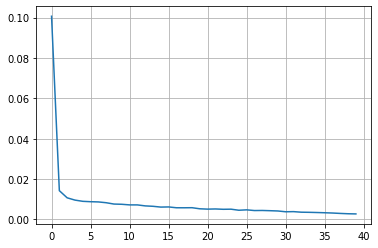

2022-06-14 18:36:33.610610: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Data from 0 to 16
Mean Absolute Error: 12502.29
Mean Absolute Percenatge Error: 41.22


Test Data from 1 to 17
Mean Absolute Error: 12593.27
Mean Absolute Percenatge Error: 40.59


Test Data from 2 to 18
Mean Absolute Error: 11708.06
Mean Absolute Percenatge Error: 36.46


Test Data from 3 to 19
Mean Absolute Error: 11144.29
Mean Absolute Percenatge Error: 33.89


Test Data from 4 to 20
Mean Absolute Error: 13007.86
Mean Absolute Percenatge Error: 44.36


Test Data from 5 to 21
Mean Absolute Error: 11407.43
Mean Absolute Percenatge Error: 39.10


Test Data from 6 to 22
Mean Absolute Error: 10436.09
Mean Absolute Percenatge Error: 35.92


Test Data from 7 to 23
Mean Absolute Error: 10342.27
Mean Absolute Percenatge Error: 35.18


Test Data from 8 to 24
Mean Absolute Error: 10468.94
Mean Absolute Percenatge Error: 36.22


Test Data from 9 to 25
Mean Absolute Error: 10499.46
Mean Absolute Percenatge Error: 37.59


Test Data from 10 to 26
Mean Absolute Error: 10397.96
Mean Absolute Pe

 20%|████████▏                                | 1/5 [23:43<1:34:55, 1423.89s/it]

Test Data from 23 to 39
Mean Absolute Error: 2302.82
Mean Absolute Percenatge Error: 5.93


Test Data from 24 to 40
Mean Absolute Error: 2570.61
Mean Absolute Percenatge Error: 6.59


Test Data from 25 to 41
Mean Absolute Error: 2478.44
Mean Absolute Percenatge Error: 6.33


Test Data from 26 to 42
Mean Absolute Error: 2592.64
Mean Absolute Percenatge Error: 6.56


Test Data from 27 to 43
Mean Absolute Error: 2382.47
Mean Absolute Percenatge Error: 6.14


Test Data from 28 to 44
Mean Absolute Error: 1788.23
Mean Absolute Percenatge Error: 4.63


Test Data from 29 to 45
Mean Absolute Error: 1430.78
Mean Absolute Percenatge Error: 3.52


Test Data from 30 to 46
Mean Absolute Error: 1227.34
Mean Absolute Percenatge Error: 2.86


X_train_multi_gru: (996, 20, 54) Y_train_multi_gru: (996, 7)
X_test_multi_gru: (35, 20, 54) Y_test_multi_gru: (35, 7)
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Pa

2022-06-14 18:36:39.122187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 56s 2s/step - loss: 0.0998
Epoch 2/40
32/32 [==============================] - 53s 2s/step - loss: 0.0160
Epoch 3/40
32/32 [==============================] - 53s 2s/step - loss: 0.0112
Epoch 4/40
32/32 [==============================] - 53s 2s/step - loss: 0.0098
Epoch 5/40
32/32 [==============================] - 53s 2s/step - loss: 0.0088
Epoch 6/40
32/32 [==============================] - 55s 2s/step - loss: 0.0084
Epoch 7/40
32/32 [==============================] - 54s 2s/step - loss: 0.0084
Epoch 8/40
32/32 [==============================] - 55s 2s/step - loss: 0.0078
Epoch 9/40
32/32 [==============================] - 54s 2s/step - loss: 0.0077
Epoch 10/40
32/32 [==============================] - 54s 2s/step - loss: 0.0076
Epoch 11/40
32/32 [==============================] - 54s 2s/step - loss: 0.0072
Epoch 12/40
32/32 [==============================] - 54s 2s/step - loss: 0.0068
Epoch 13/40
32/32 [==============================] - 53s 2s/

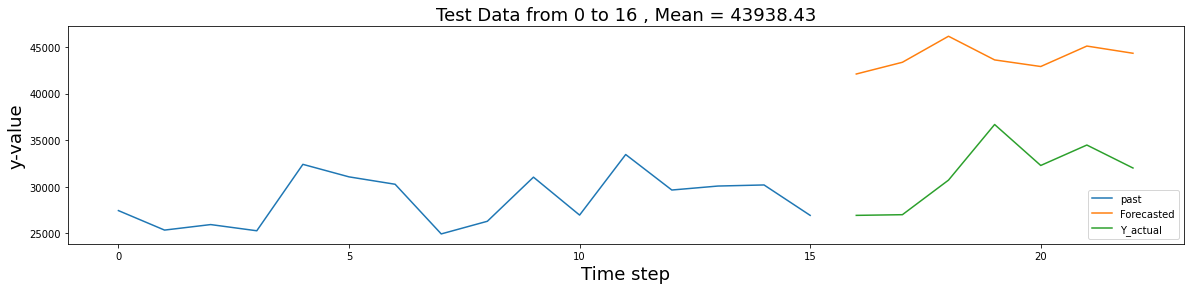

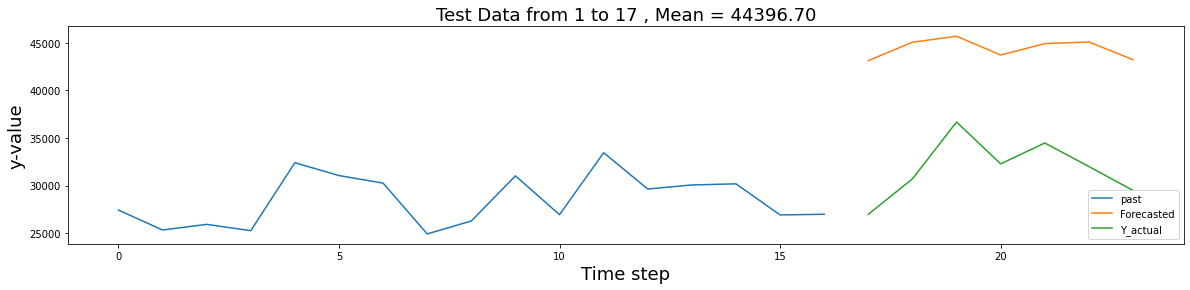

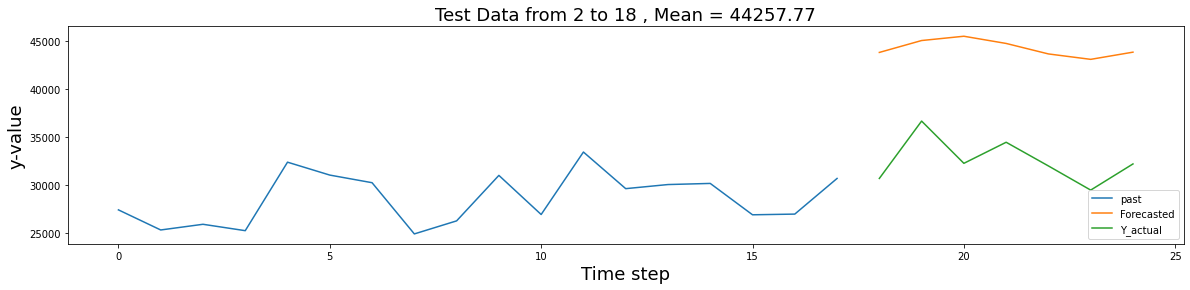

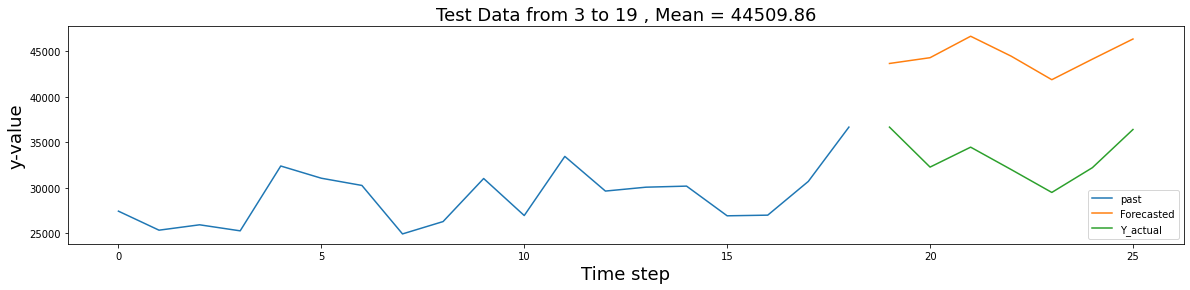

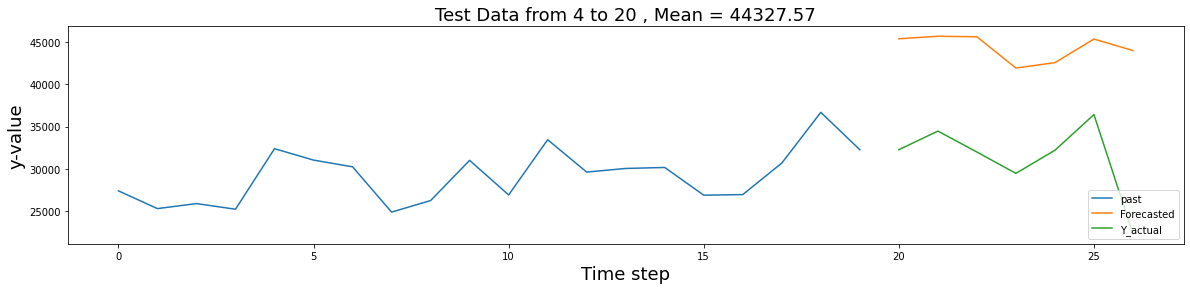

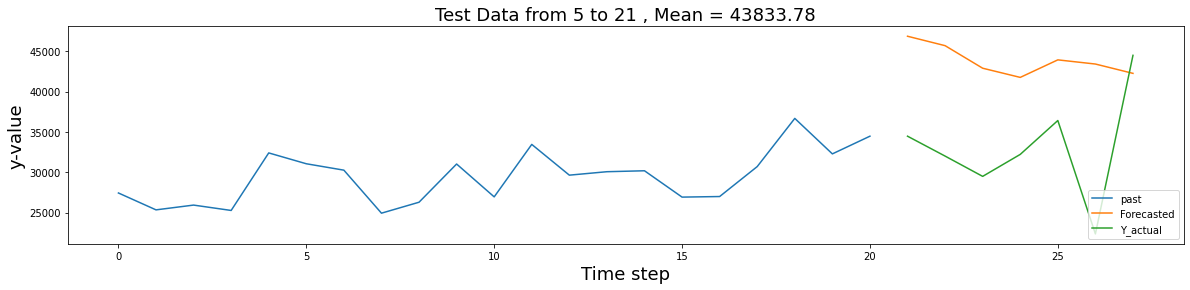

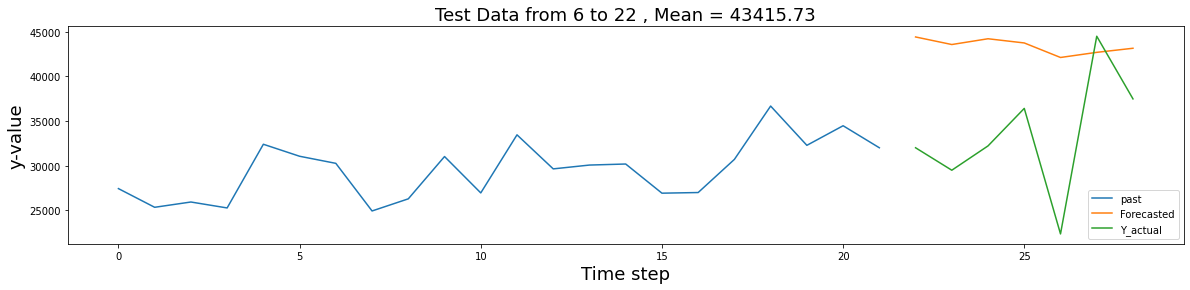

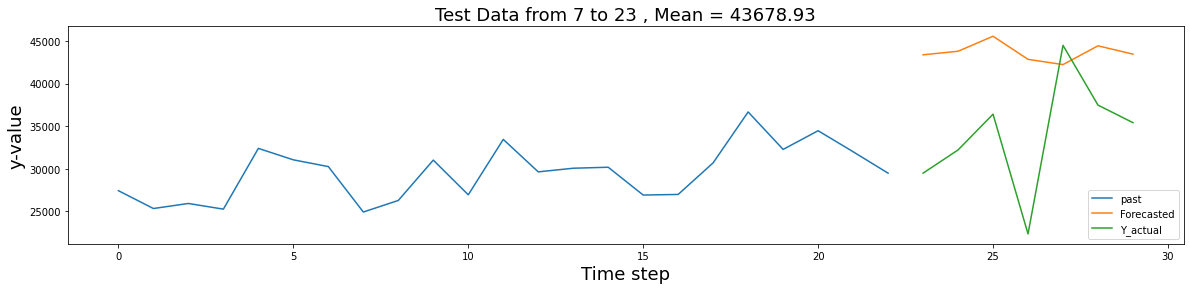

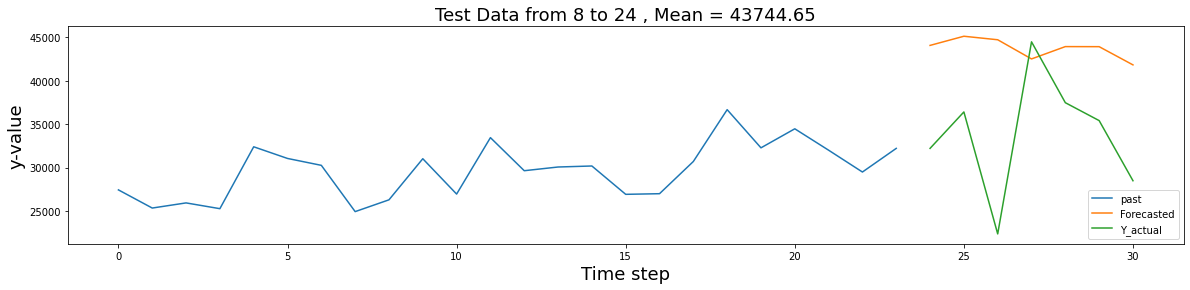

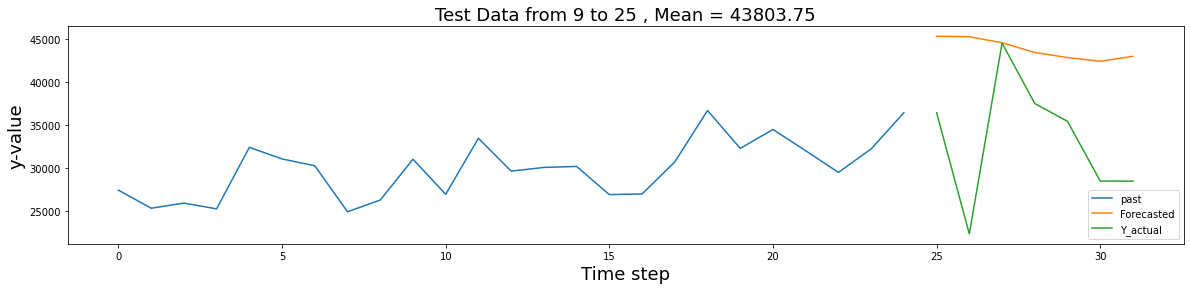

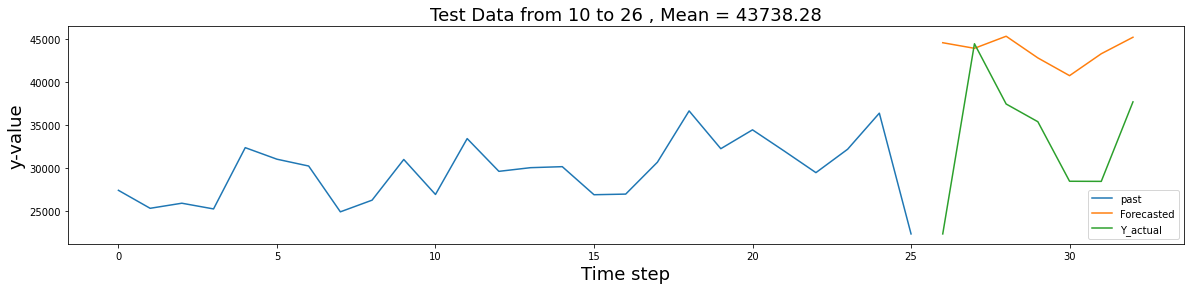

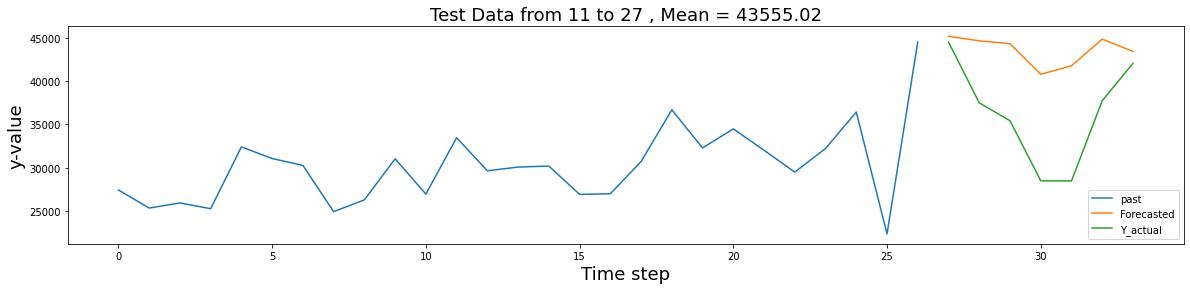

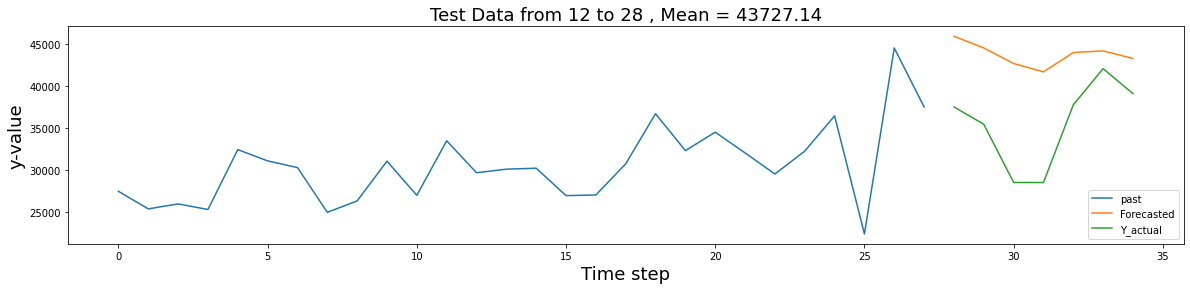

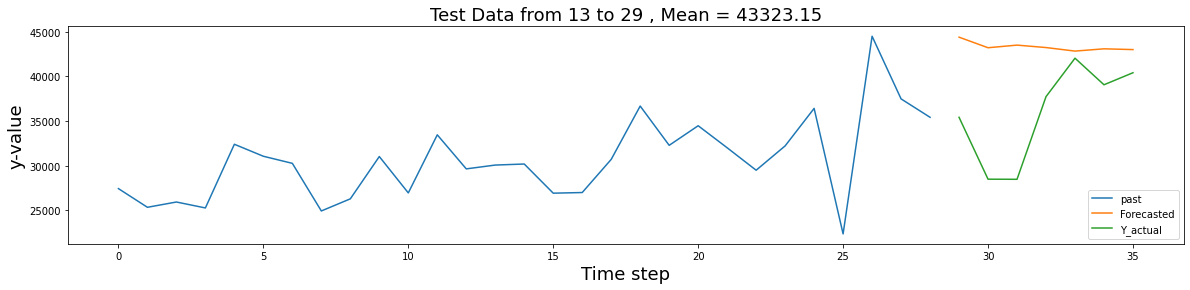

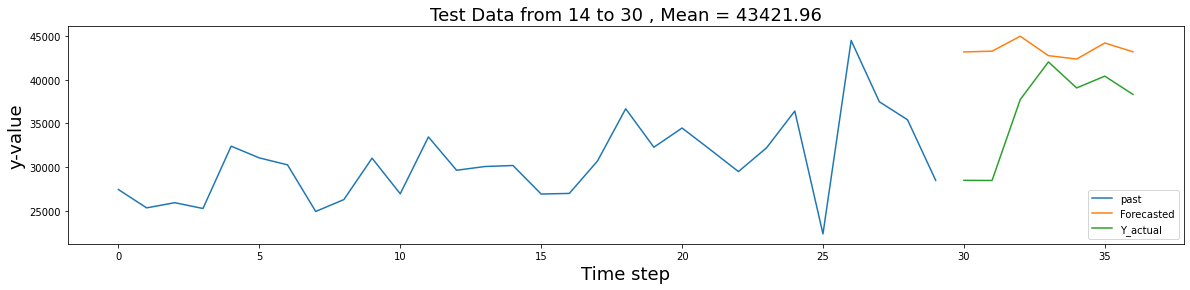

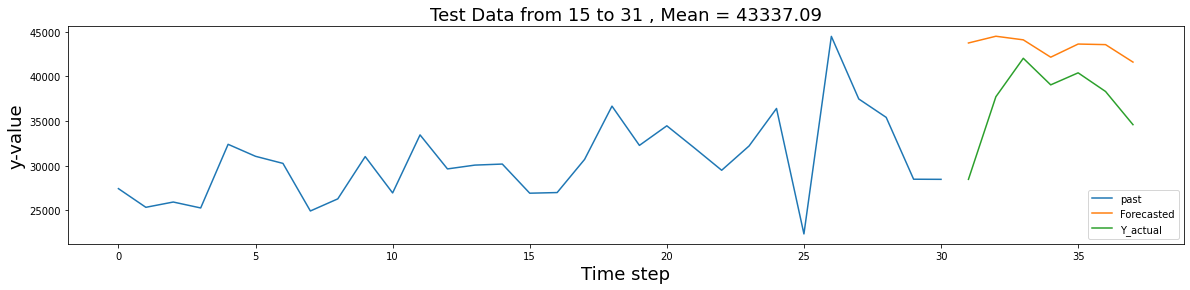

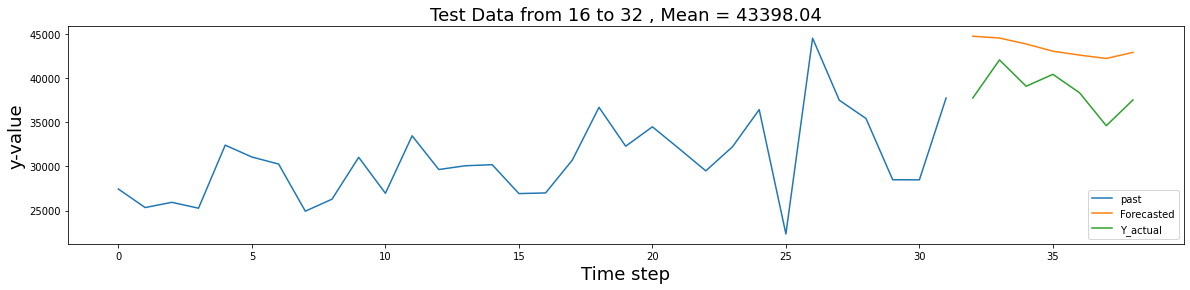

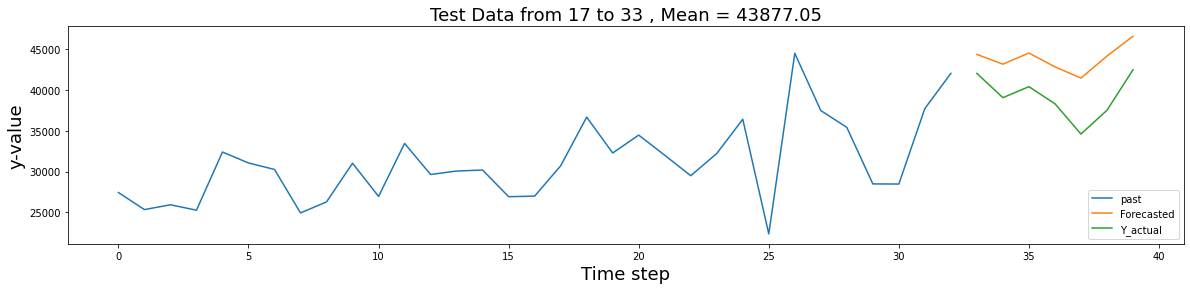

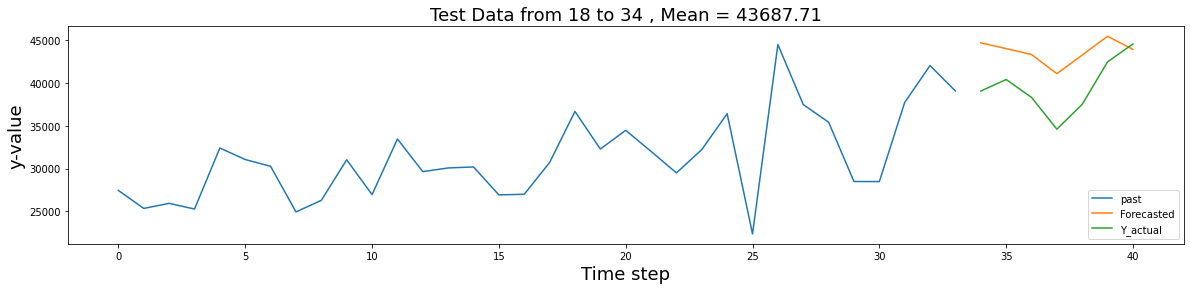

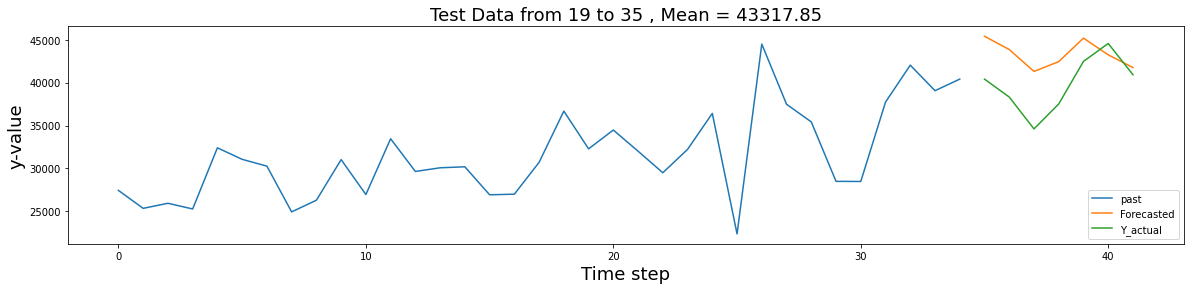

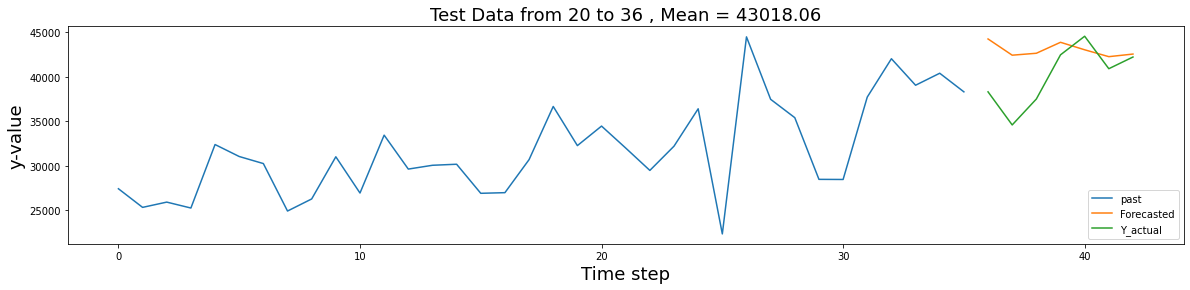

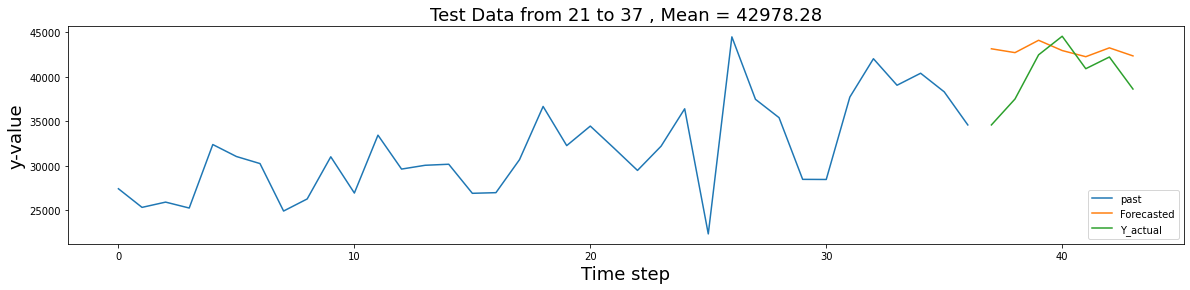

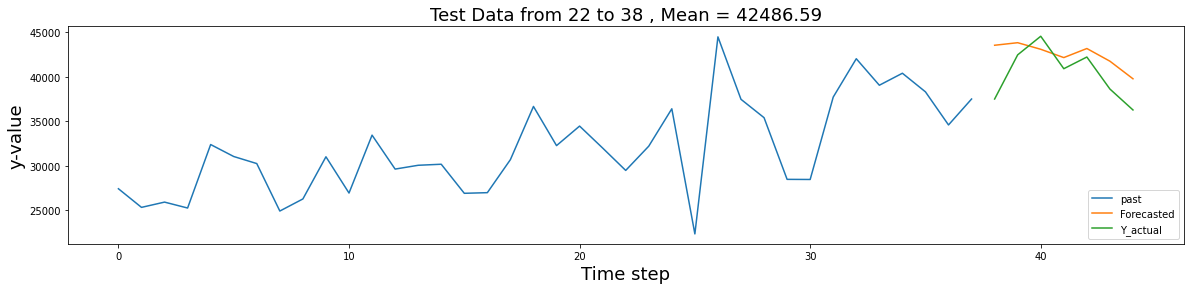

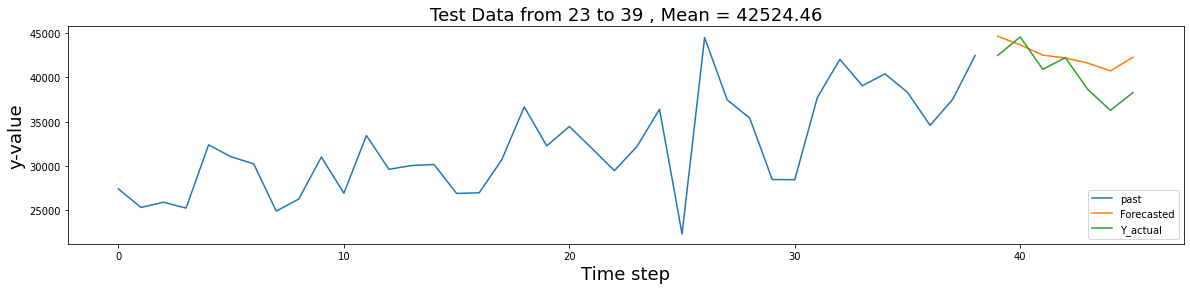

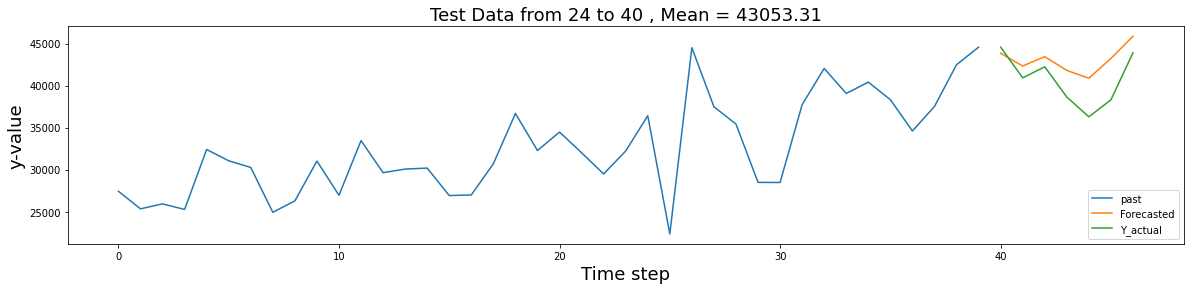

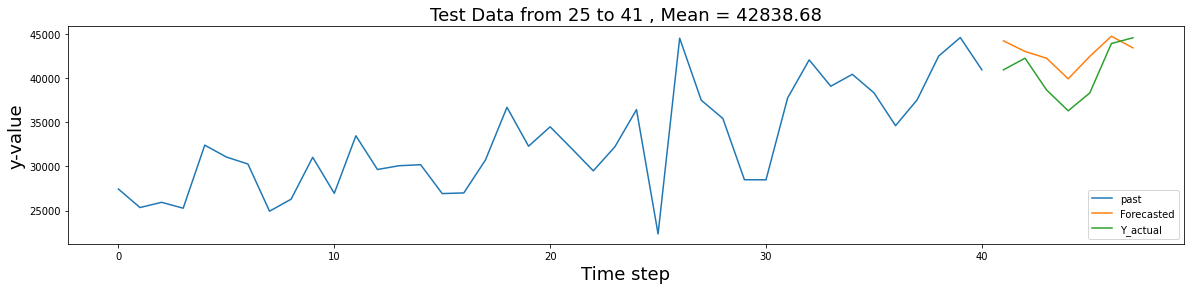

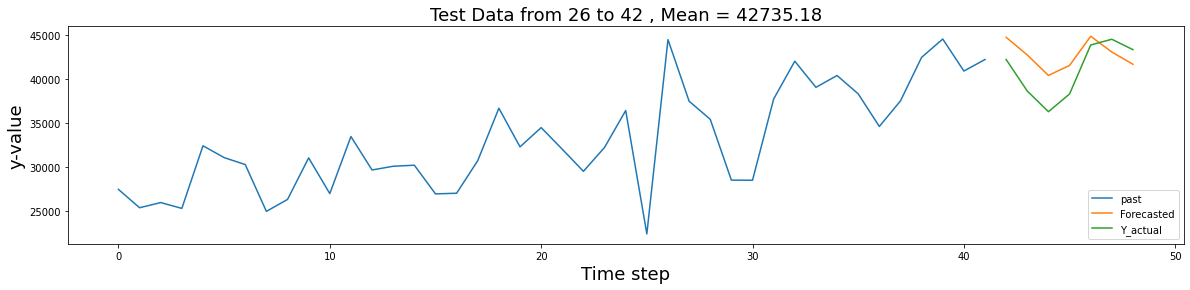

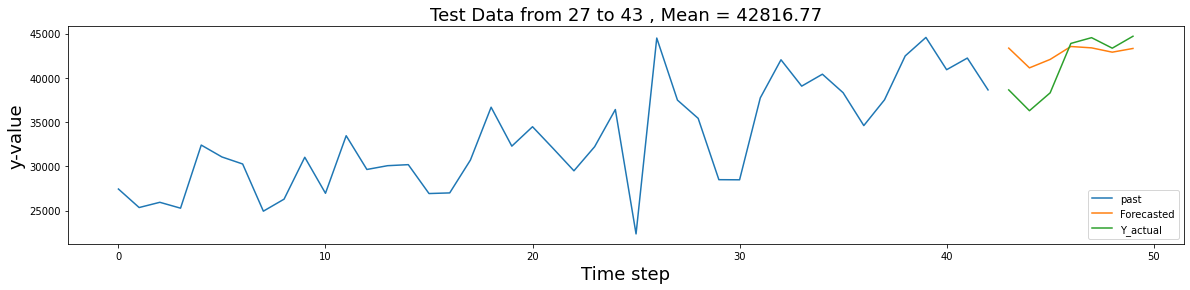

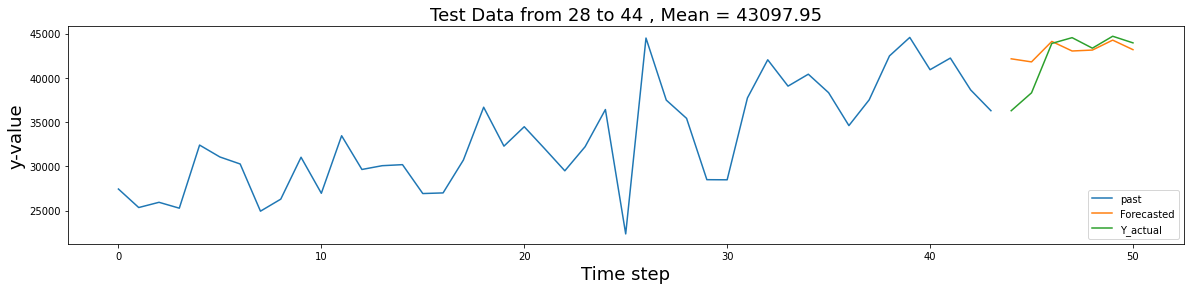

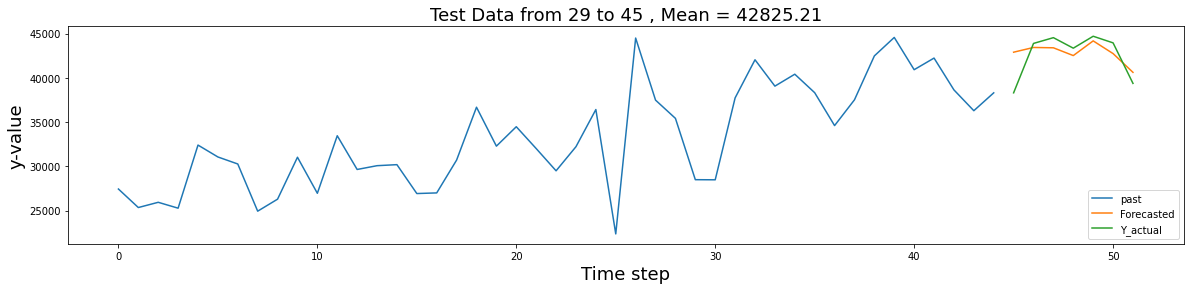

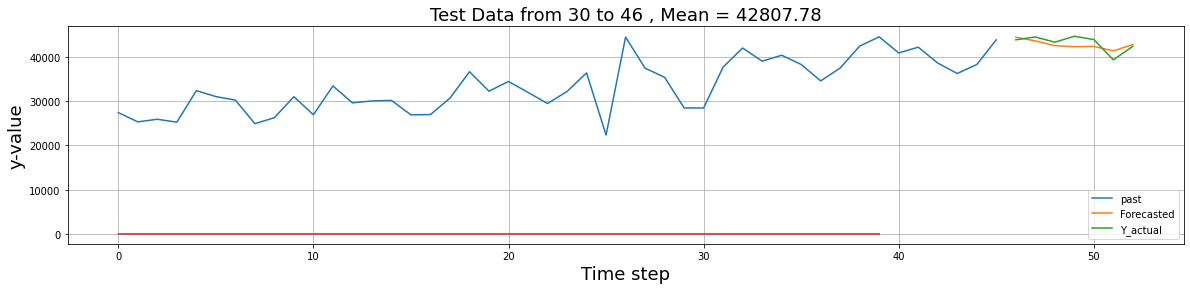

2022-06-14 19:12:52.427930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
 40%|███████████████▌                       | 2/5 [1:00:03<1:33:25, 1868.44s/it]

Test Data from 0 to 20
Mean Absolute Error: 11042.65
Mean Absolute Percenatge Error: 38.39


Test Data from 1 to 21
Mean Absolute Error: 9492.80
Mean Absolute Percenatge Error: 33.52


Test Data from 2 to 22
Mean Absolute Error: 8967.10
Mean Absolute Percenatge Error: 31.27


Test Data from 3 to 23
Mean Absolute Error: 9018.07
Mean Absolute Percenatge Error: 31.17


Test Data from 4 to 24
Mean Absolute Error: 8598.28
Mean Absolute Percenatge Error: 30.65


Test Data from 5 to 25
Mean Absolute Error: 9249.79
Mean Absolute Percenatge Error: 33.51


Test Data from 6 to 26
Mean Absolute Error: 9102.61
Mean Absolute Percenatge Error: 32.51


Test Data from 7 to 27
Mean Absolute Error: 6428.22
Mean Absolute Percenatge Error: 19.83


Test Data from 8 to 28
Mean Absolute Error: 6811.67
Mean Absolute Percenatge Error: 21.13


Test Data from 9 to 29
Mean Absolute Error: 6661.67
Mean Absolute Percenatge Error: 20.81


Test Data from 10 to 30
Mean Absolute Error: 5899.99
Mean Absolute Percenatge E

2022-06-14 19:12:58.649864: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 42s 1s/step - loss: 0.1024
Epoch 2/40
31/31 [==============================] - 40s 1s/step - loss: 0.0131
Epoch 3/40
31/31 [==============================] - 40s 1s/step - loss: 0.0101
Epoch 4/40
31/31 [==============================] - 40s 1s/step - loss: 0.0093
Epoch 5/40
31/31 [==============================] - 40s 1s/step - loss: 0.0088
Epoch 6/40
31/31 [==============================] - 40s 1s/step - loss: 0.0078
Epoch 7/40
31/31 [==============================] - 40s 1s/step - loss: 0.0075
Epoch 8/40
31/31 [==============================] - 40s 1s/step - loss: 0.0074
Epoch 9/40
31/31 [==============================] - 40s 1s/step - loss: 0.0069
Epoch 10/40
31/31 [==============================] - 40s 1s/step - loss: 0.0067
Epoch 11/40
31/31 [==============================] - 40s 1s/step - loss: 0.0065
Epoch 12/40
31/31 [==============================] - 40s 1s/step - loss: 0.0061
Epoch 13/40
31/31 [==============================] - 45s 1s/

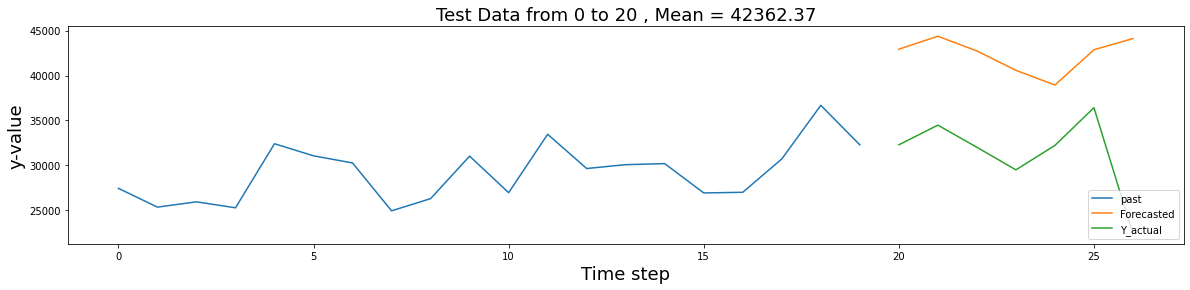

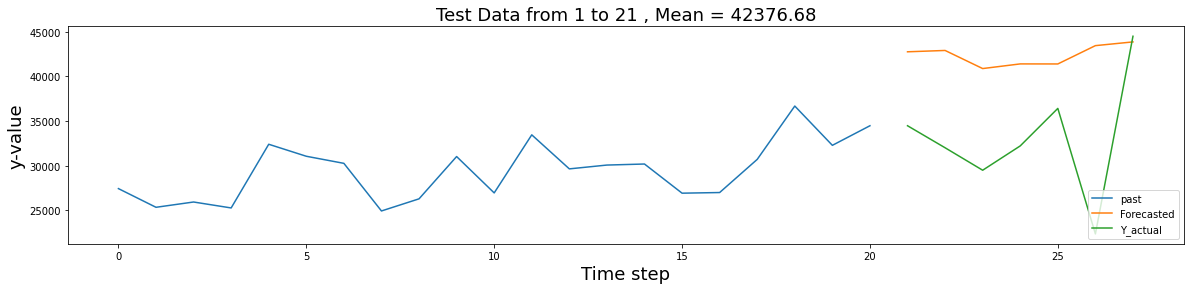

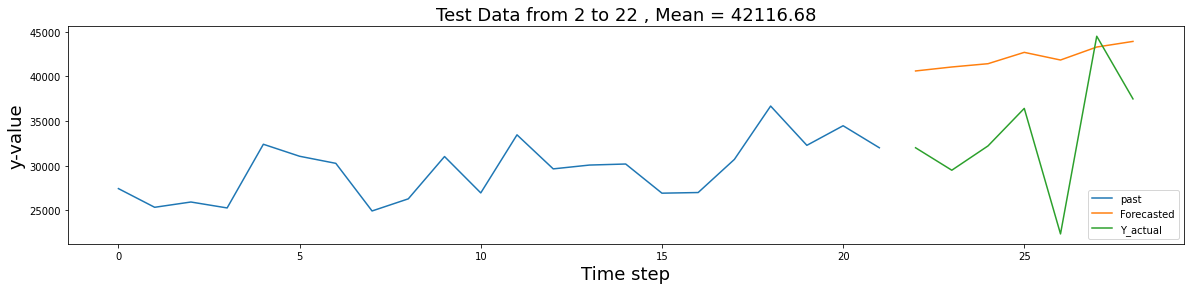

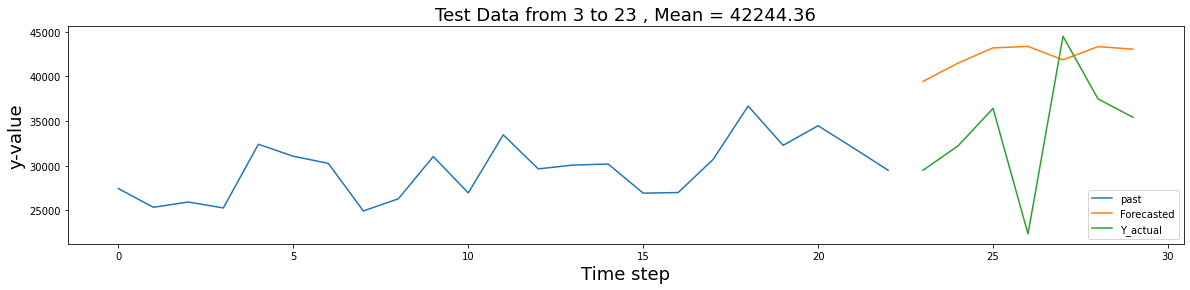

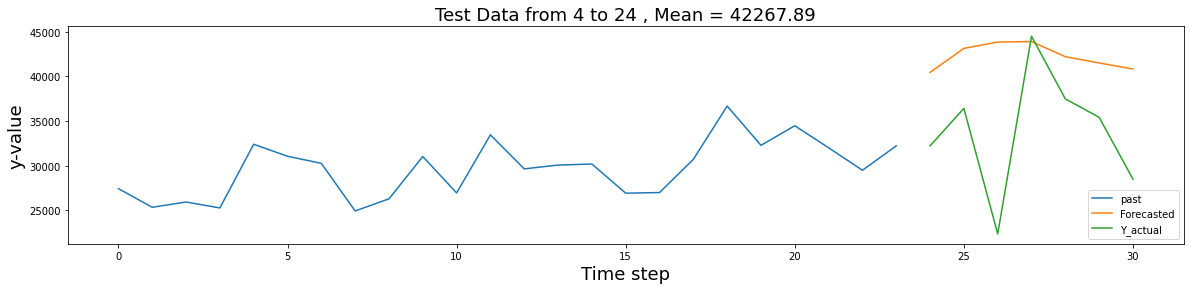

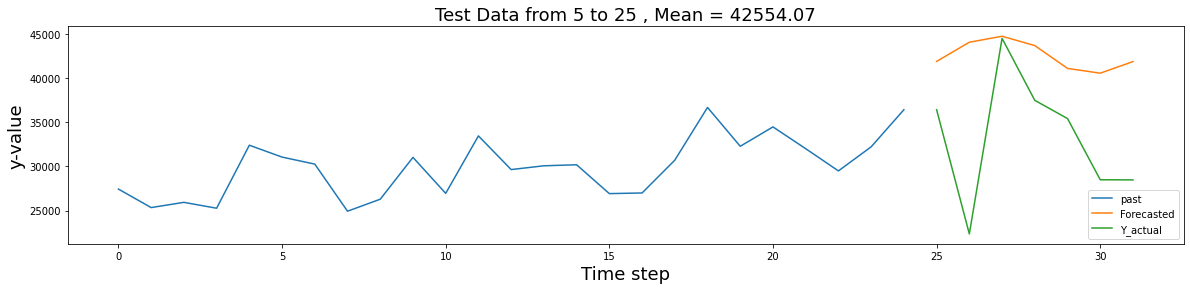

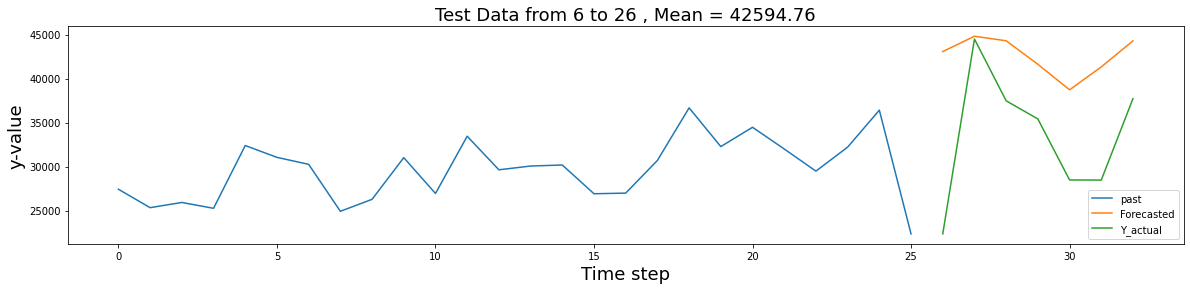

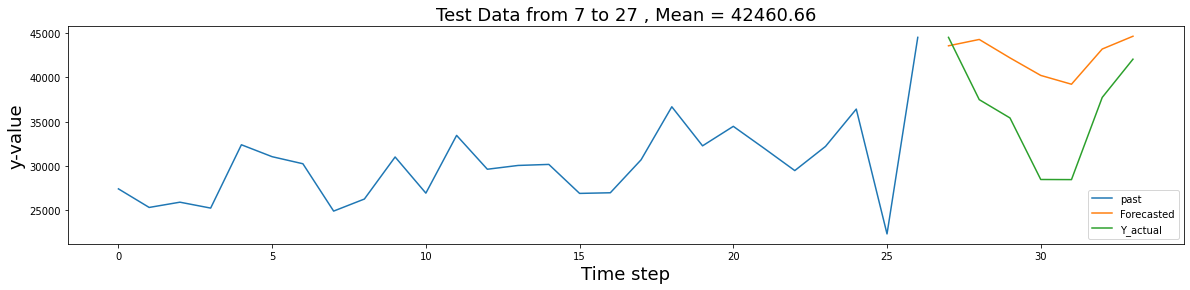

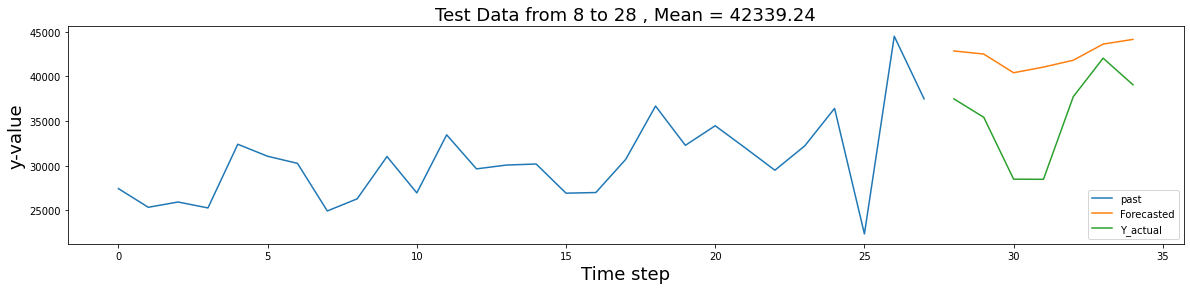

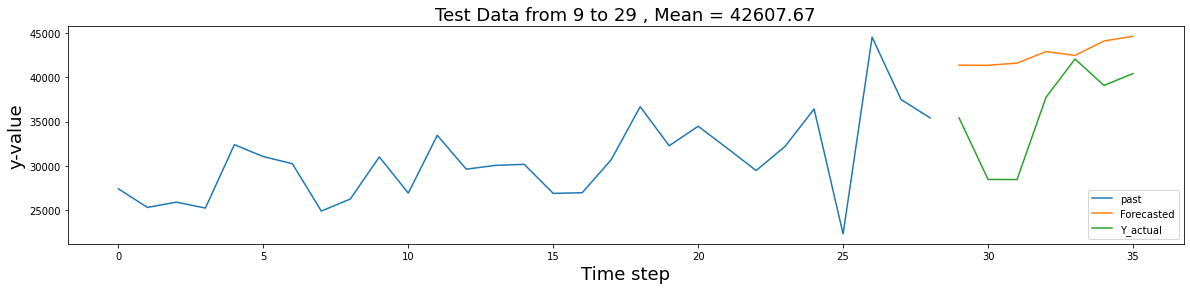

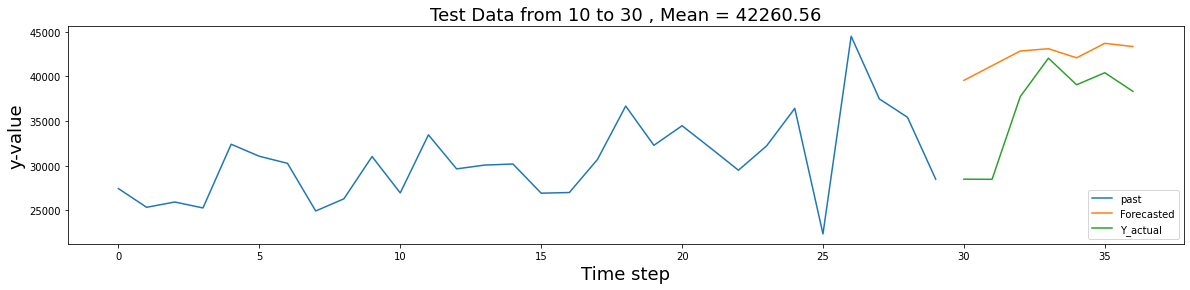

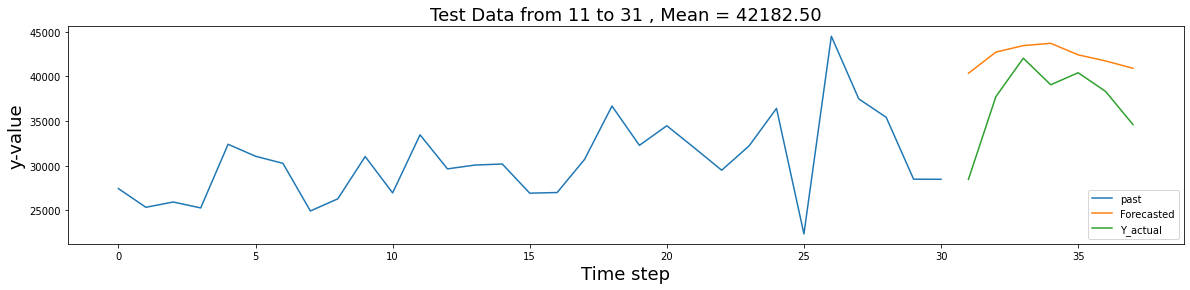

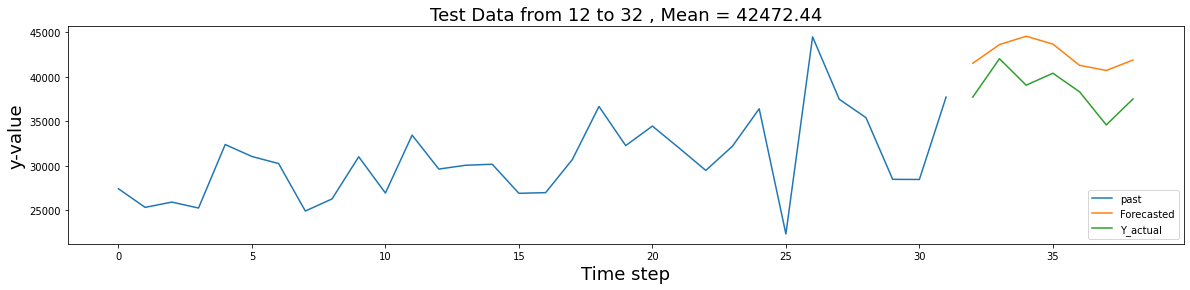

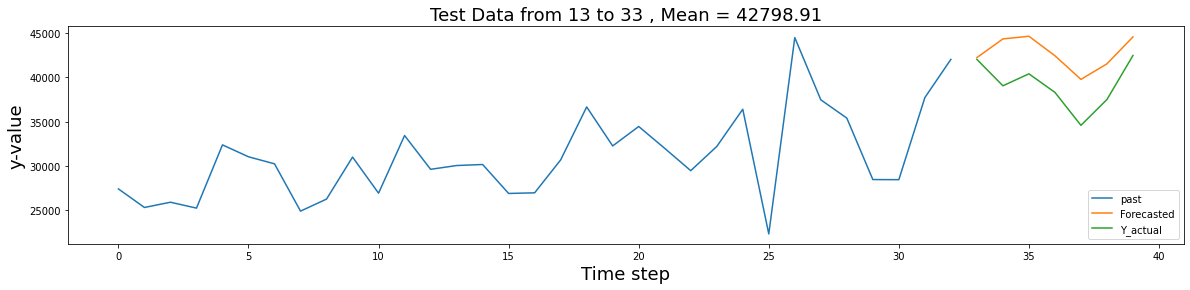

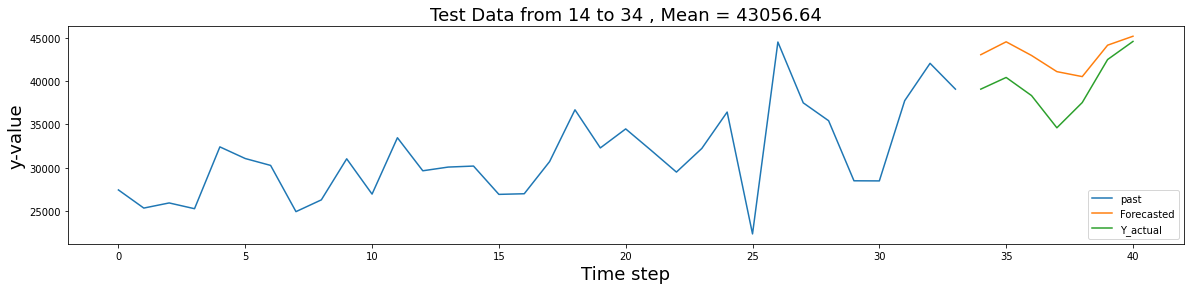

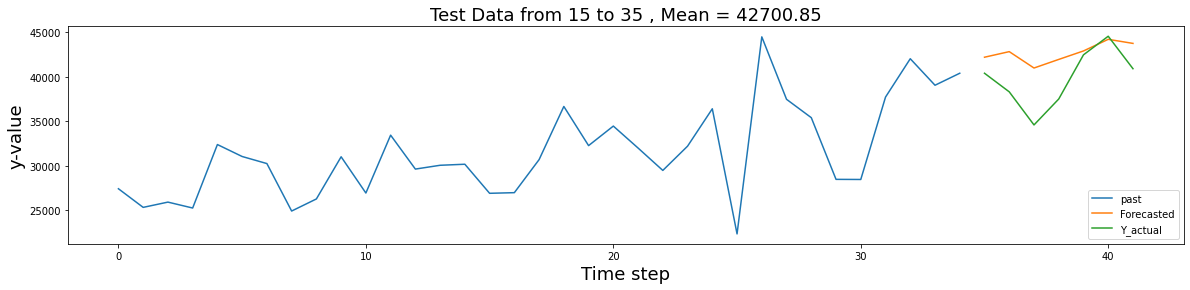

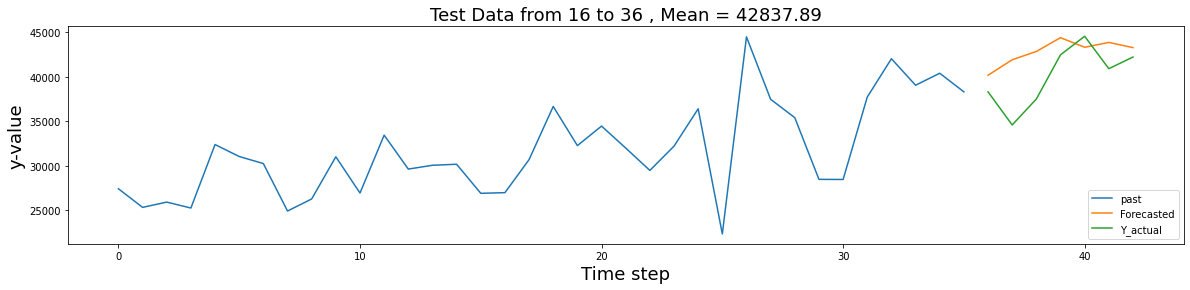

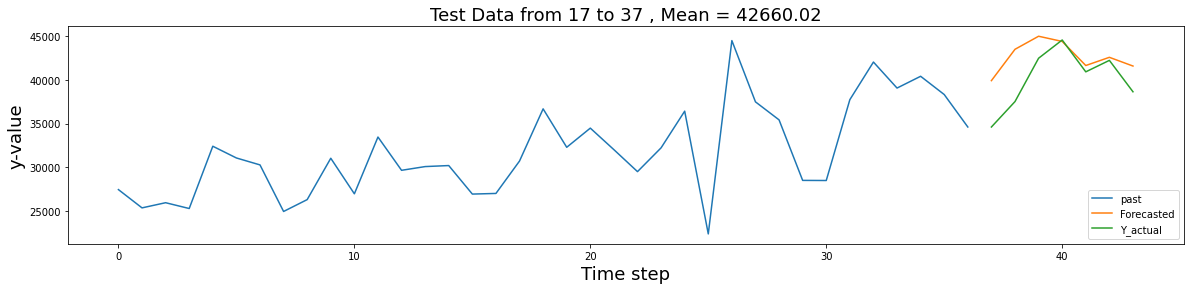

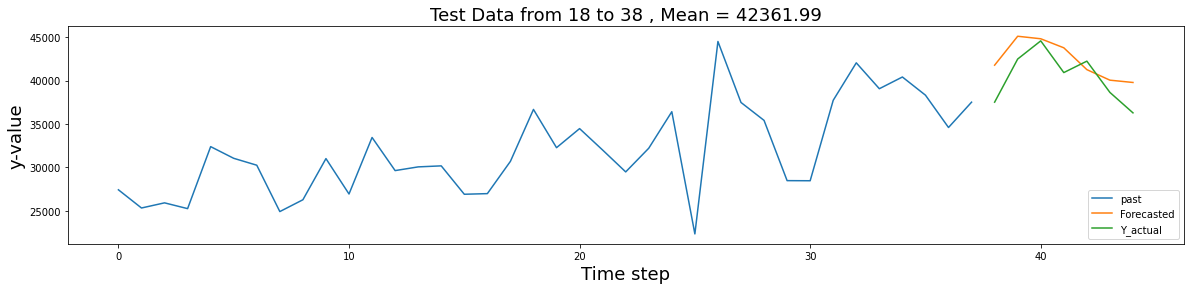

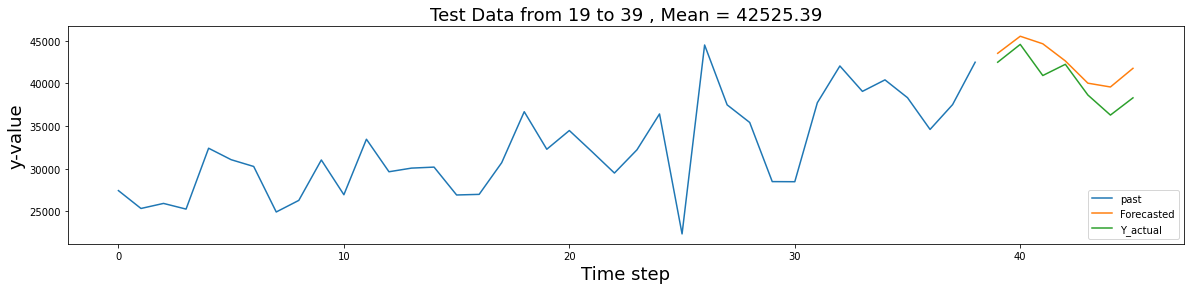

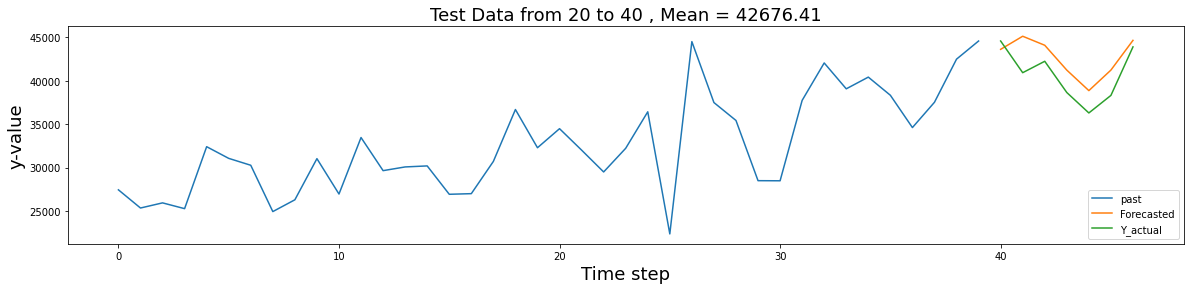

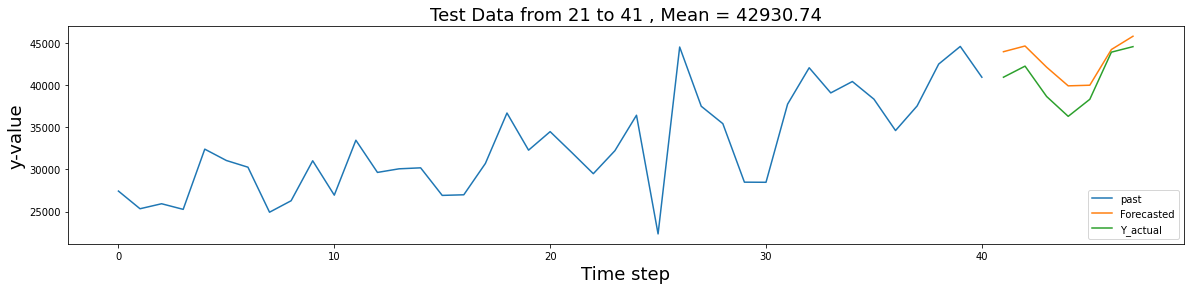

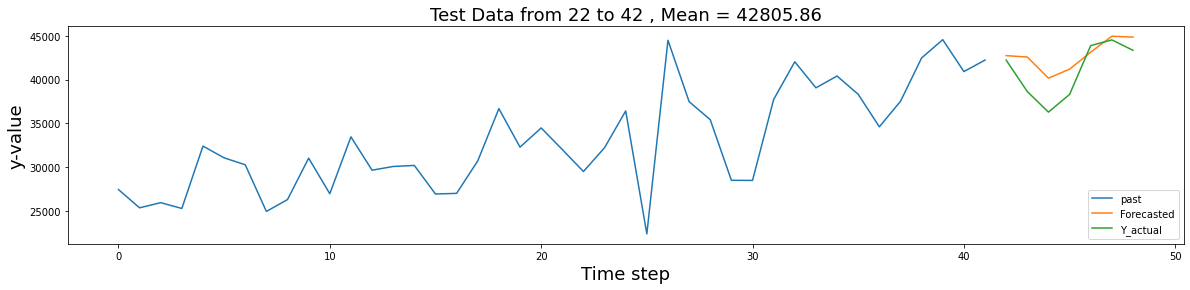

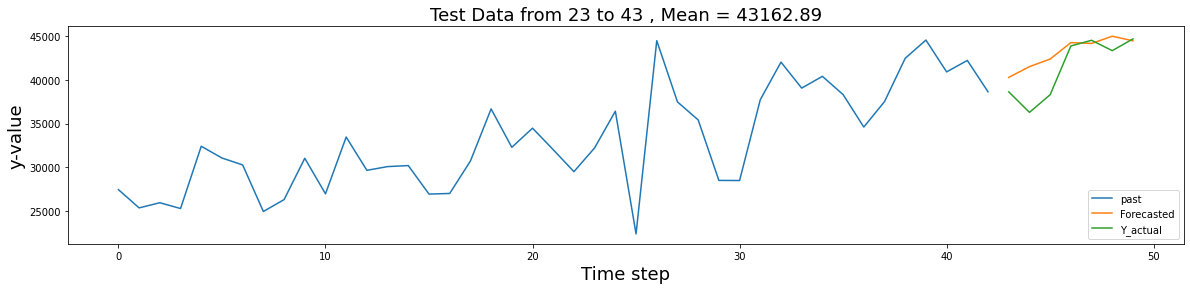

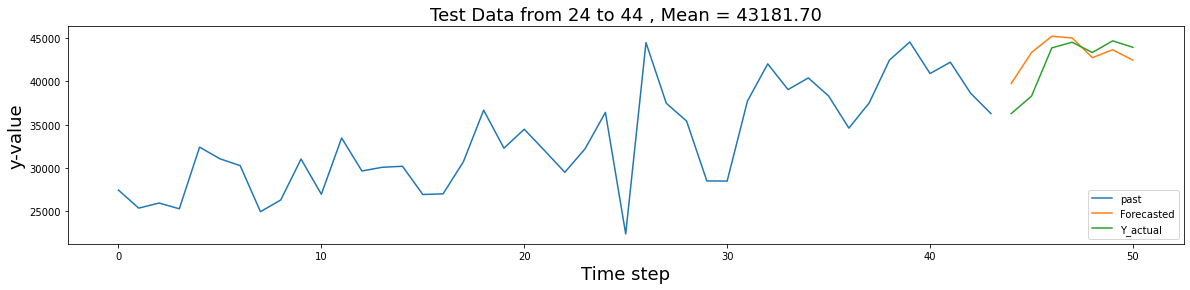

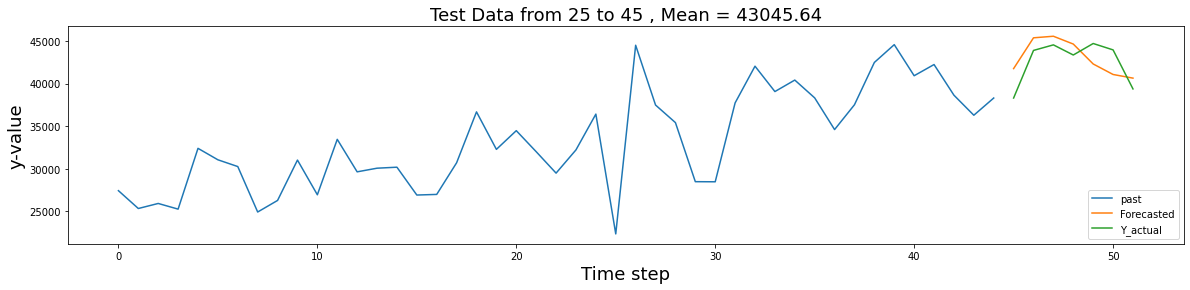

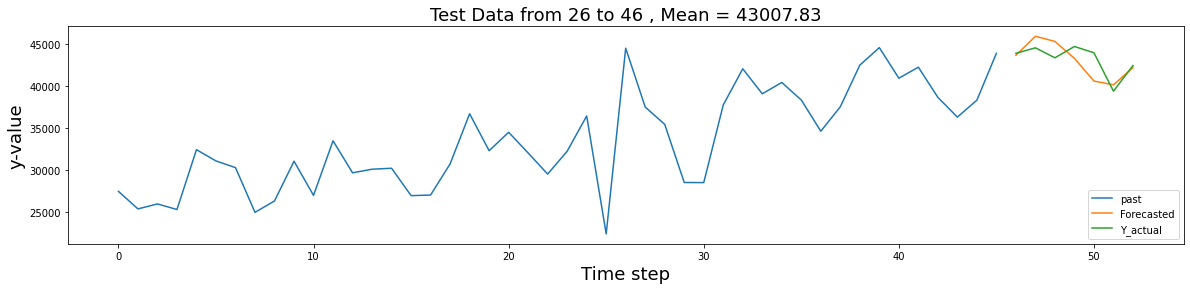

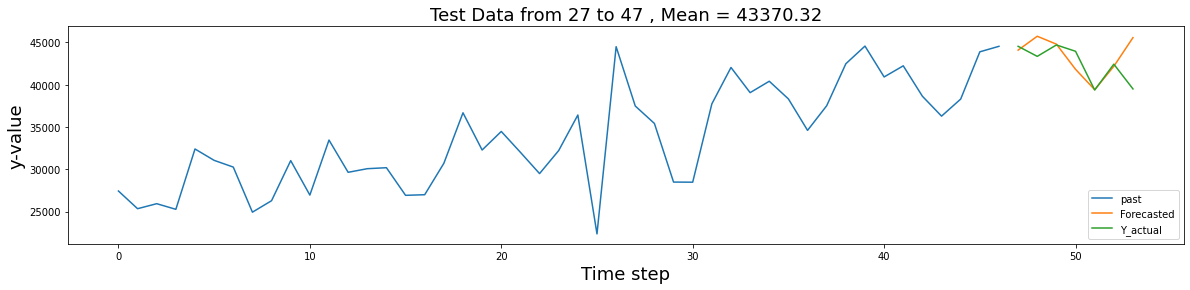

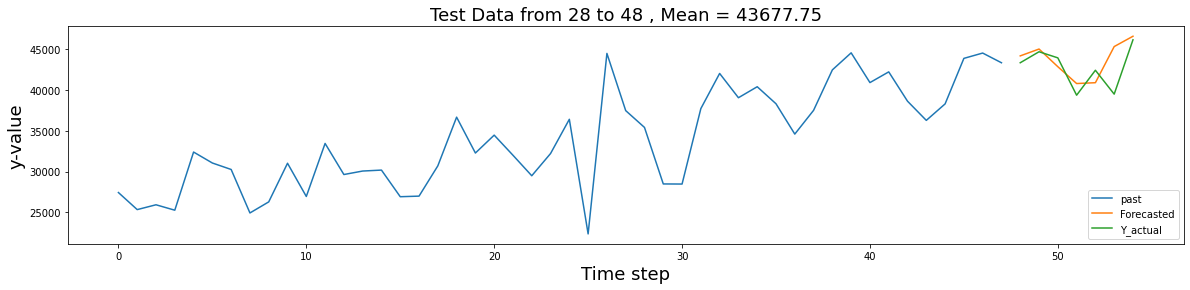

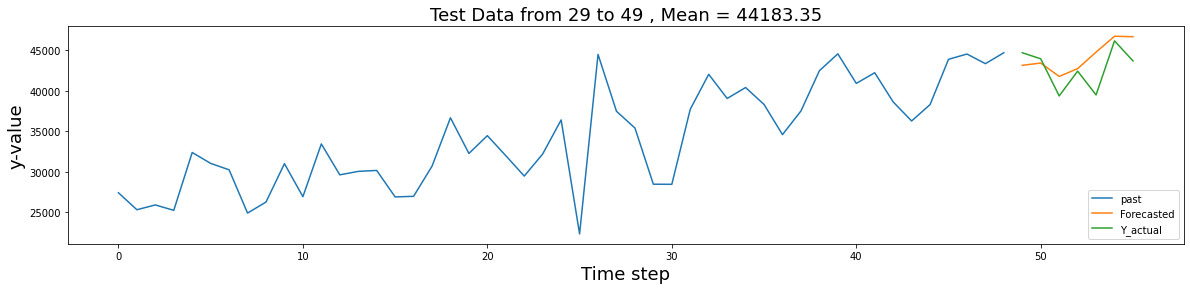

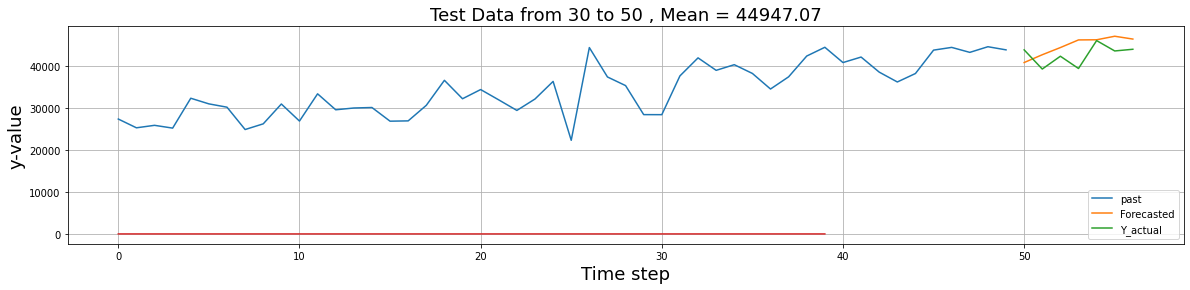

2022-06-14 19:39:53.821255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-14 19:39:58.854064: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
 60%|████████████████████████▌                | 3/5 [1:27:05<58:32, 1756.10s/it]

Test Data from 0 to 24
Mean Absolute Error: 7607.15
Mean Absolute Percenatge Error: 26.51


Test Data from 1 to 25
Mean Absolute Error: 7971.12
Mean Absolute Percenatge Error: 28.41


Test Data from 2 to 26
Mean Absolute Error: 7995.14
Mean Absolute Percenatge Error: 28.46


Test Data from 3 to 27
Mean Absolute Error: 6076.76
Mean Absolute Percenatge Error: 18.78


Test Data from 4 to 28
Mean Absolute Error: 6341.08
Mean Absolute Percenatge Error: 19.52


Test Data from 5 to 29
Mean Absolute Error: 4850.02
Mean Absolute Percenatge Error: 15.66


Test Data from 6 to 30
Mean Absolute Error: 4675.09
Mean Absolute Percenatge Error: 14.78


Test Data from 7 to 31
Mean Absolute Error: 3428.42
Mean Absolute Percenatge Error: 10.30


Test Data from 8 to 32
Mean Absolute Error: 2470.57
Mean Absolute Percenatge Error: 6.59


Test Data from 9 to 33
Mean Absolute Error: 1939.98
Mean Absolute Percenatge Error: 5.21


Test Data from 10 to 34
Mean Absolute Error: 3200.23
Mean Absolute Percenatge Erro

2022-06-14 19:40:01.391716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


31/31 [==============================] - 102s 3s/step - loss: 0.0987
Epoch 2/40
31/31 [==============================] - 100s 3s/step - loss: 0.0142
Epoch 3/40
31/31 [==============================] - 100s 3s/step - loss: 0.0105
Epoch 4/40
31/31 [==============================] - 100s 3s/step - loss: 0.0092
Epoch 5/40
31/31 [==============================] - 100s 3s/step - loss: 0.0084
Epoch 6/40
31/31 [==============================] - 100s 3s/step - loss: 0.0080
Epoch 7/40
31/31 [==============================] - 98s 3s/step - loss: 0.0078
Epoch 8/40
31/31 [==============================] - 98s 3s/step - loss: 0.0076
Epoch 9/40
31/31 [==============================] - 98s 3s/step - loss: 0.0075
Epoch 10/40
31/31 [==============================] - 98s 3s/step - loss: 0.0068
Epoch 11/40
31/31 [==============================] - 97s 3s/step - loss: 0.0066
Epoch 12/40
31/31 [==============================] - 97s 3s/step - loss: 0.0064
Epoch 13/40
31/31 [==============================] - 9

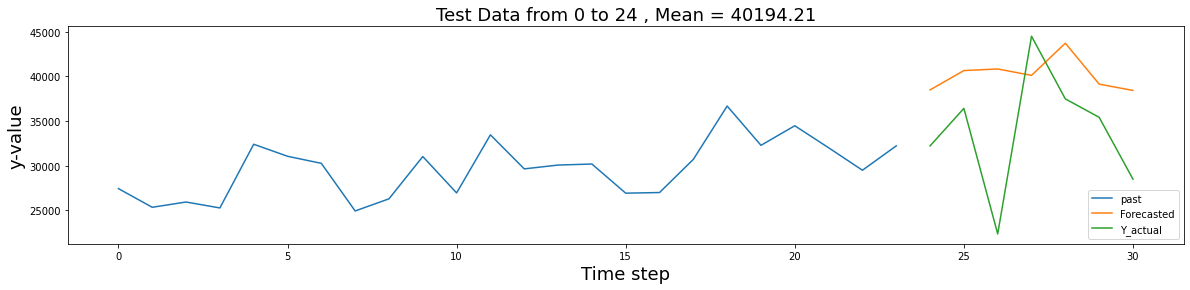

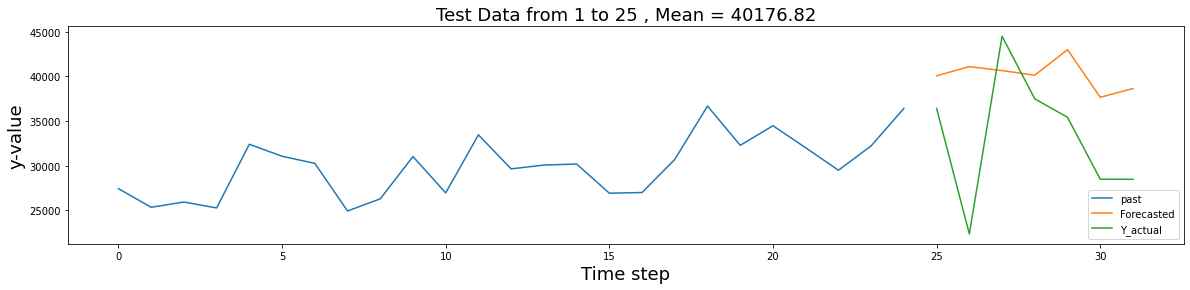

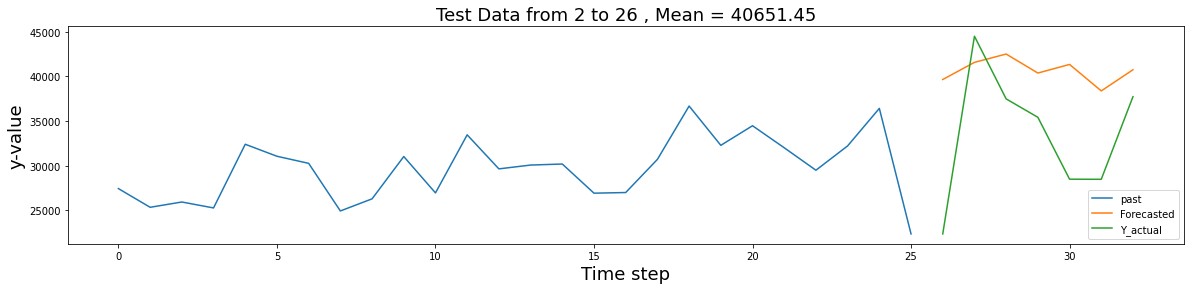

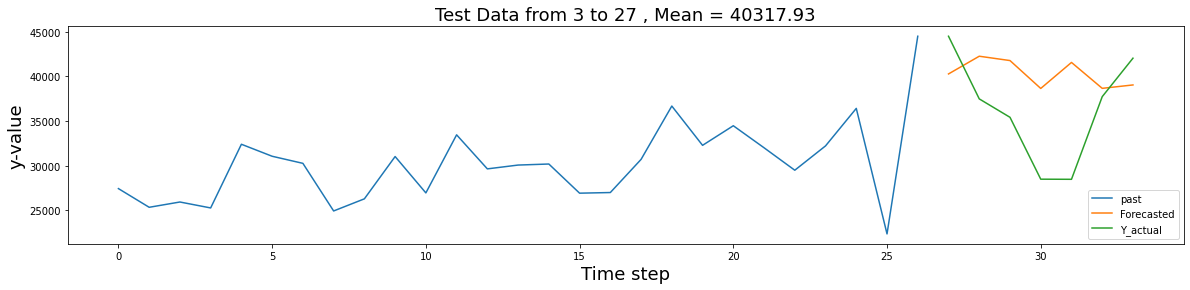

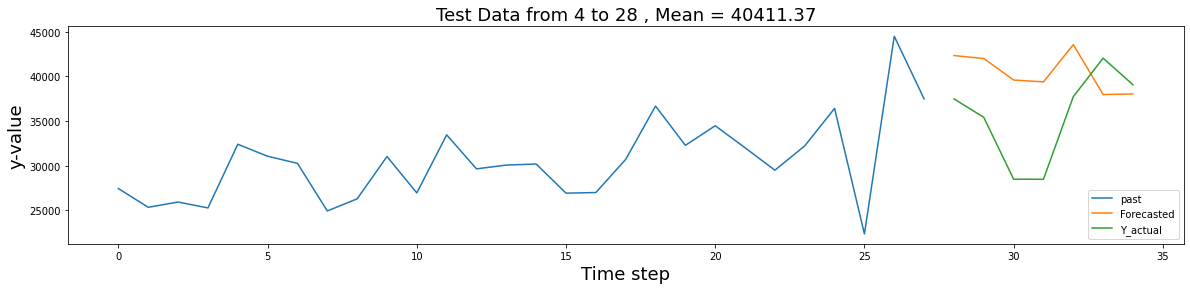

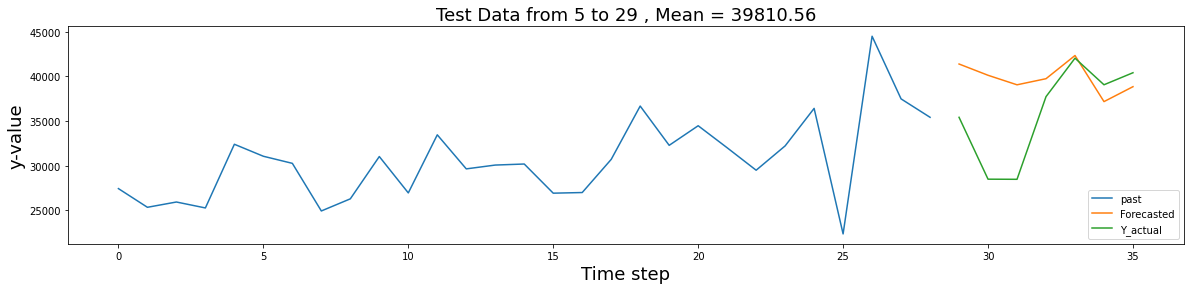

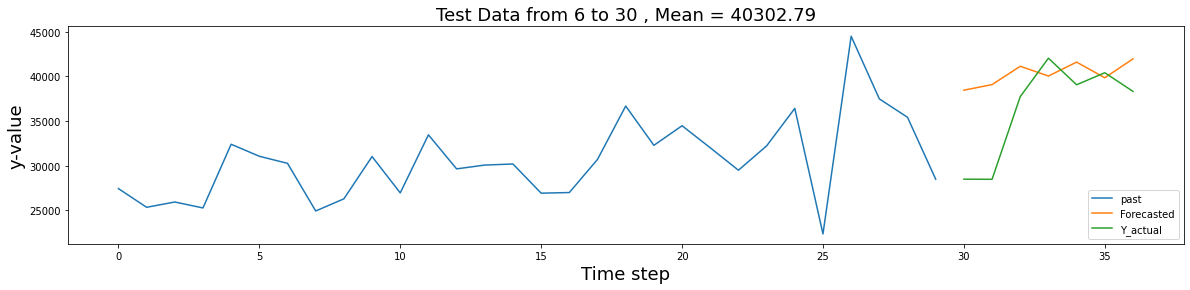

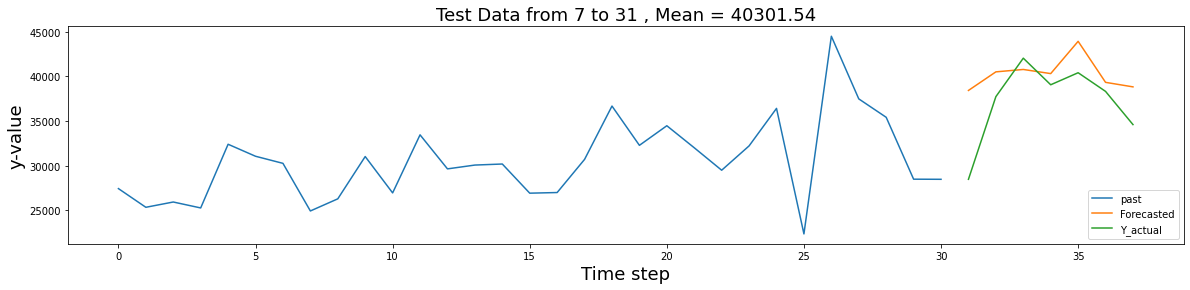

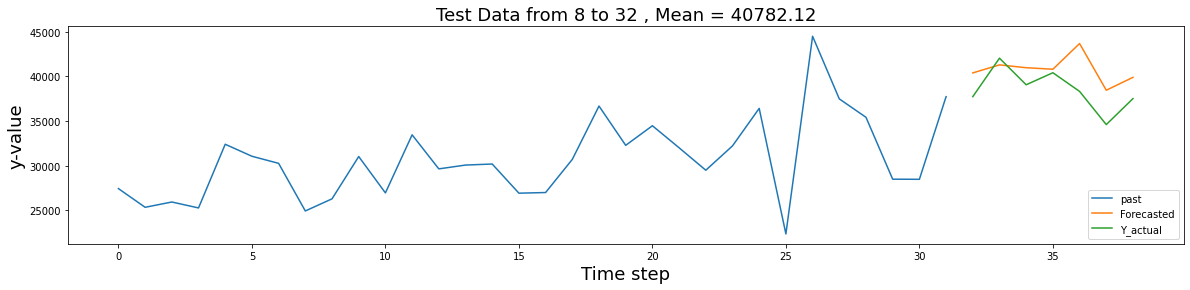

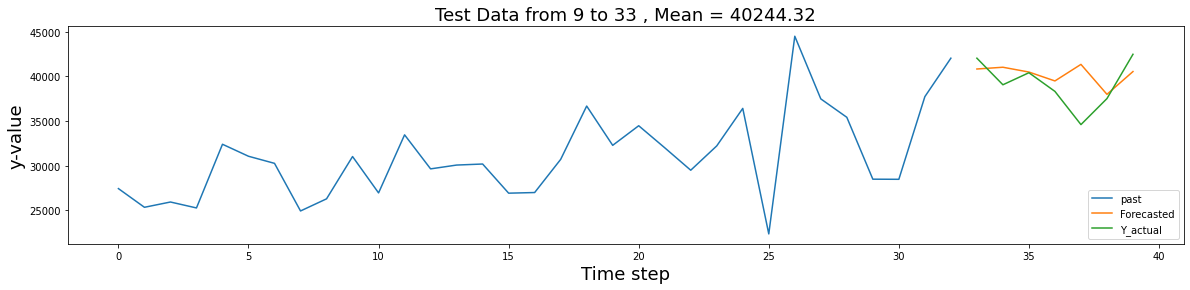

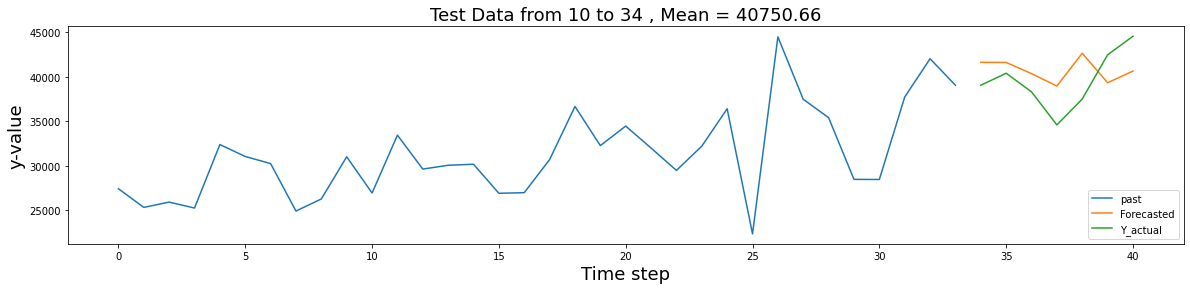

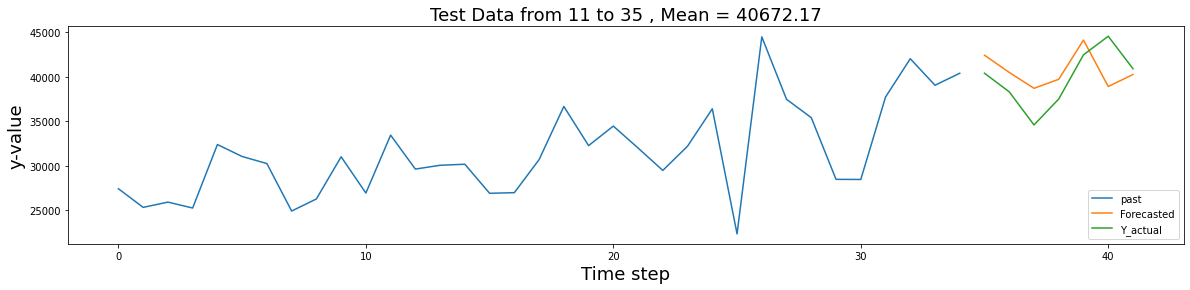

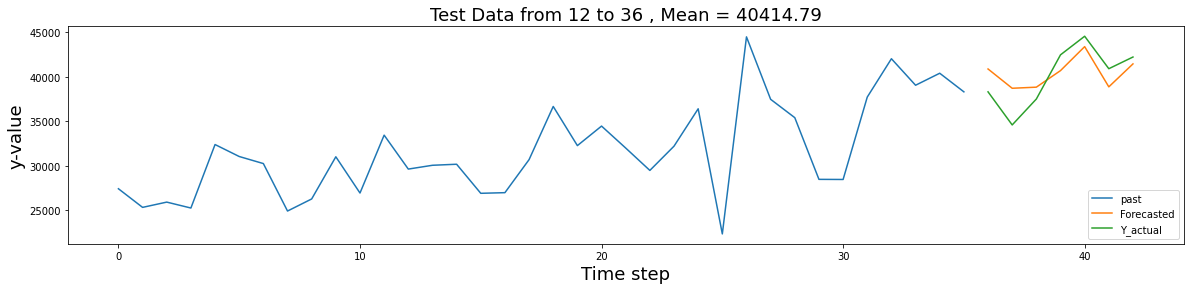

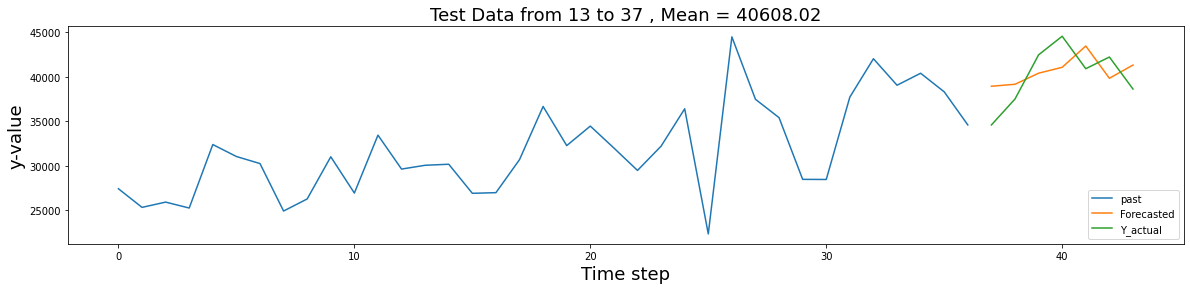

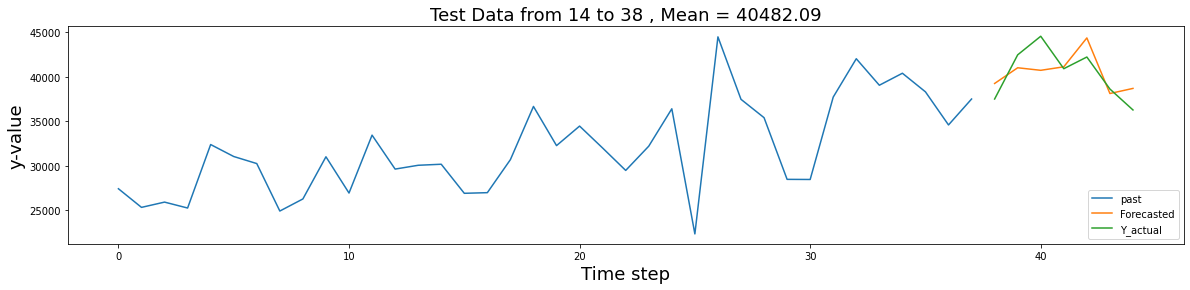

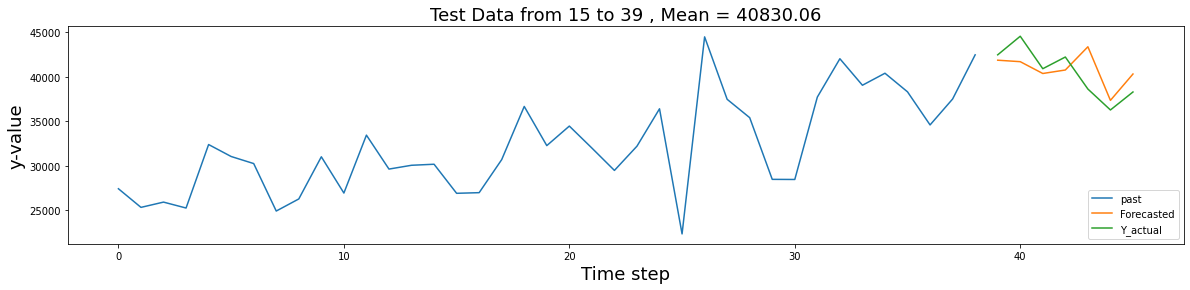

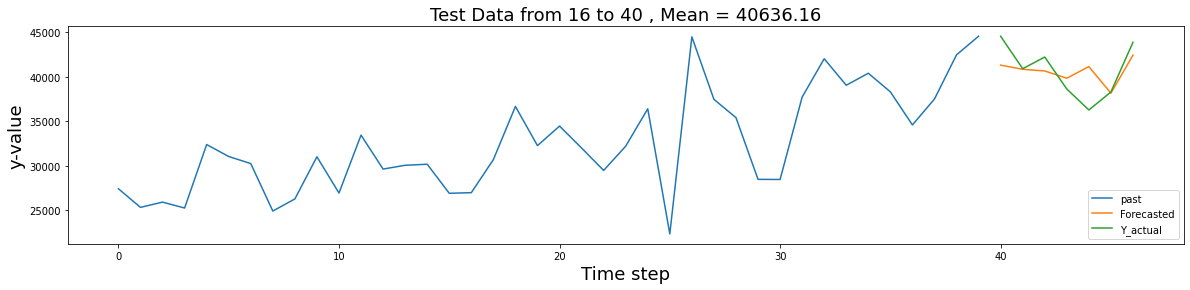

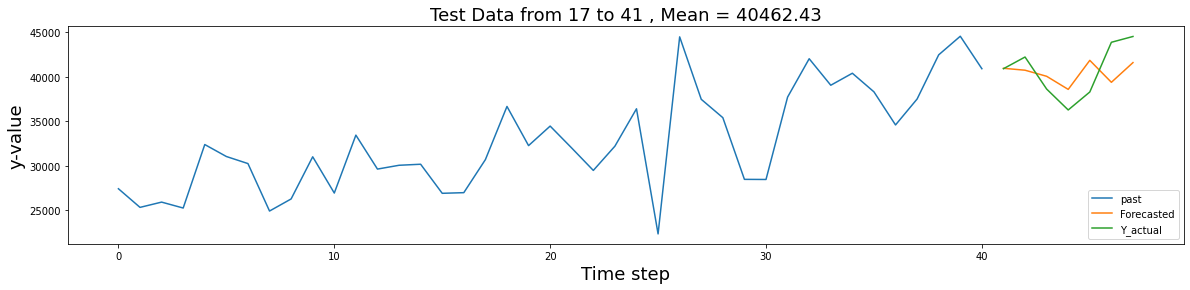

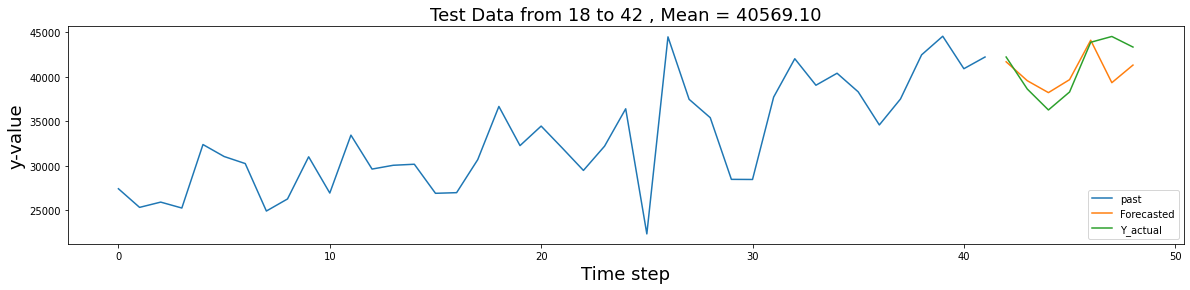

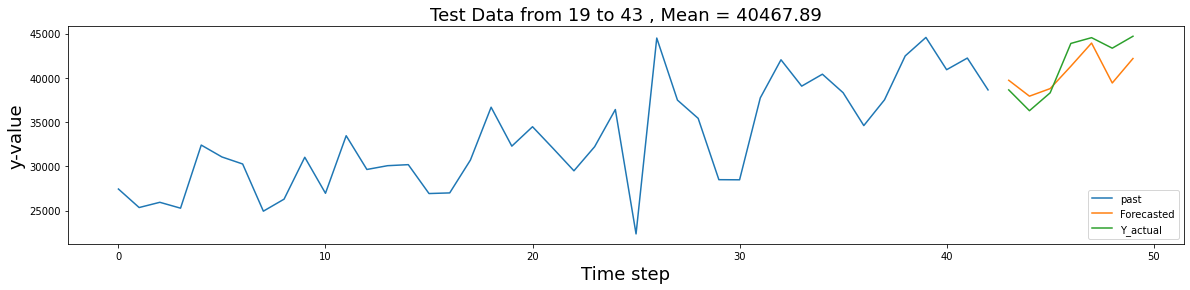

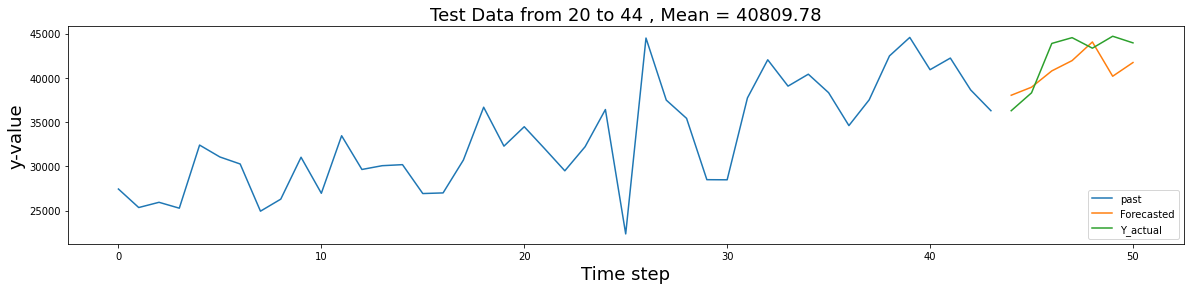

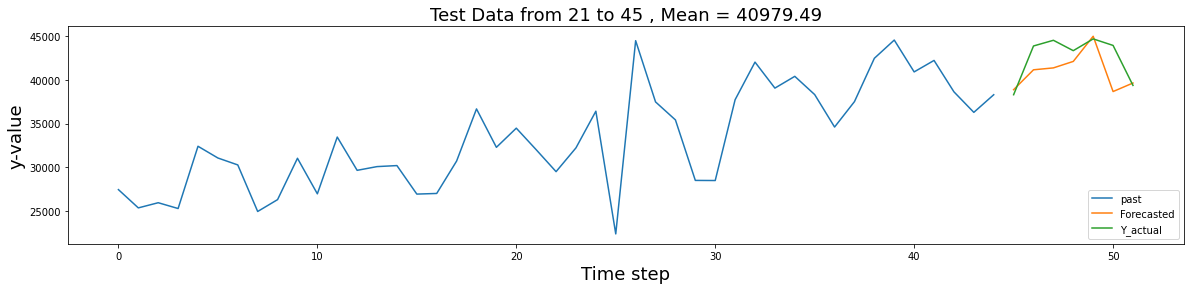

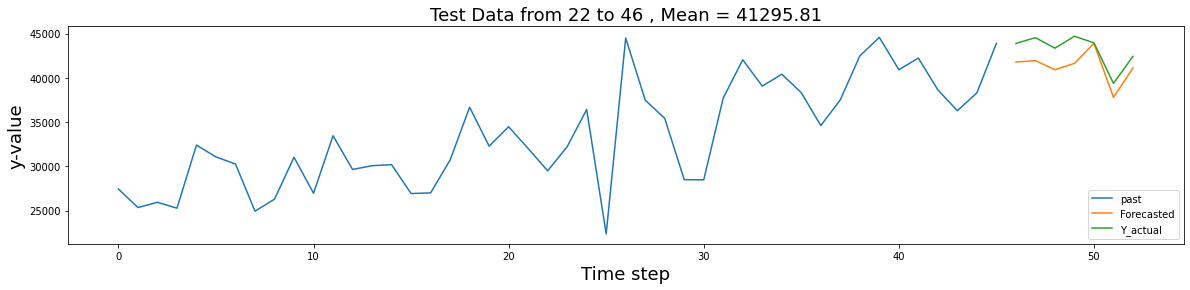

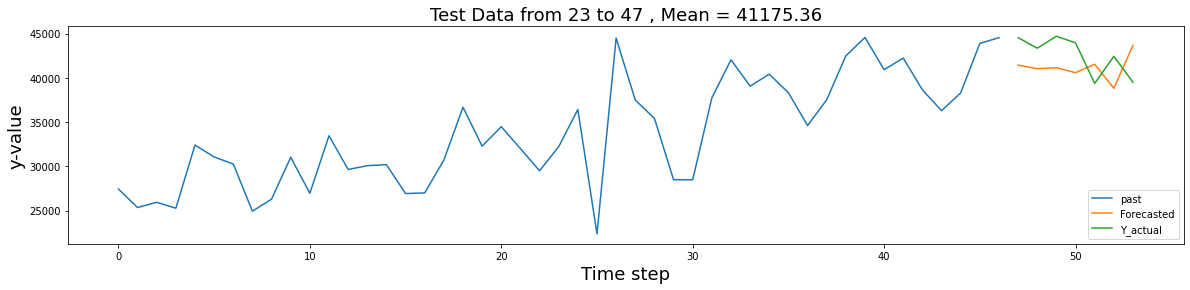

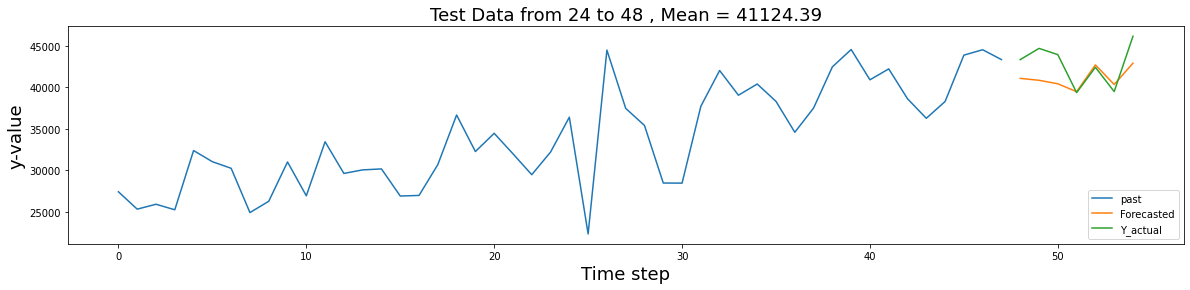

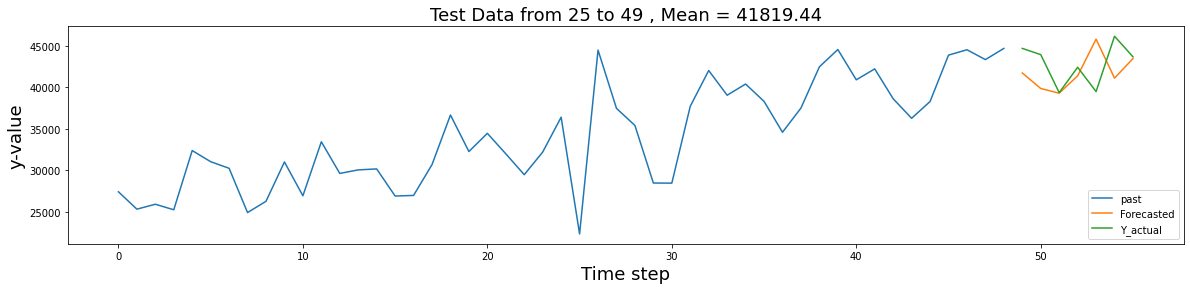

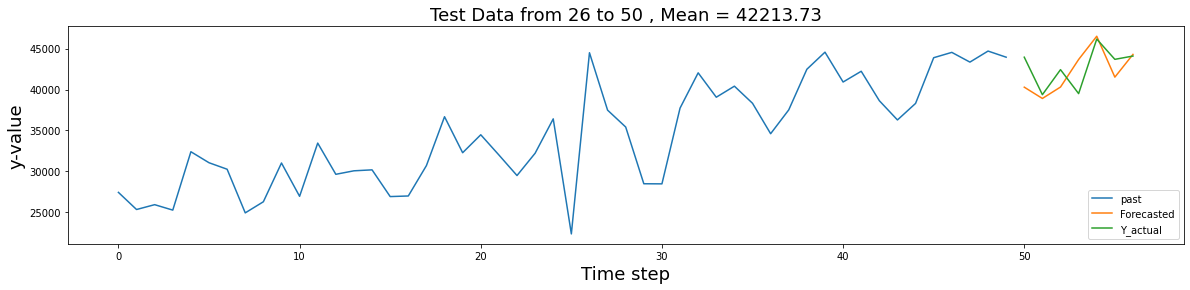

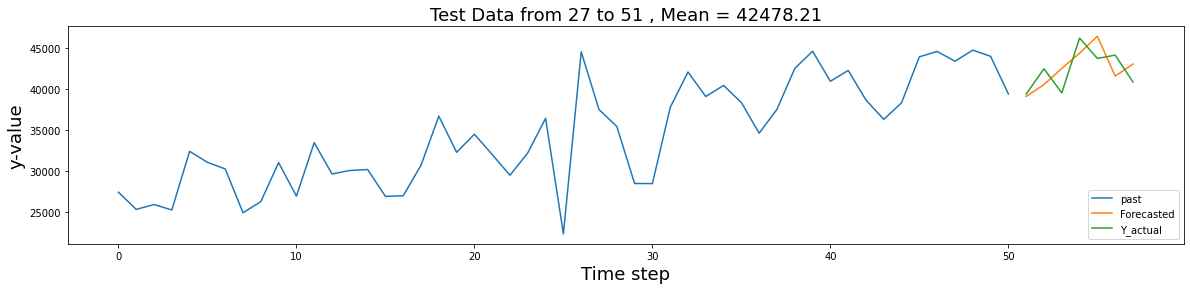

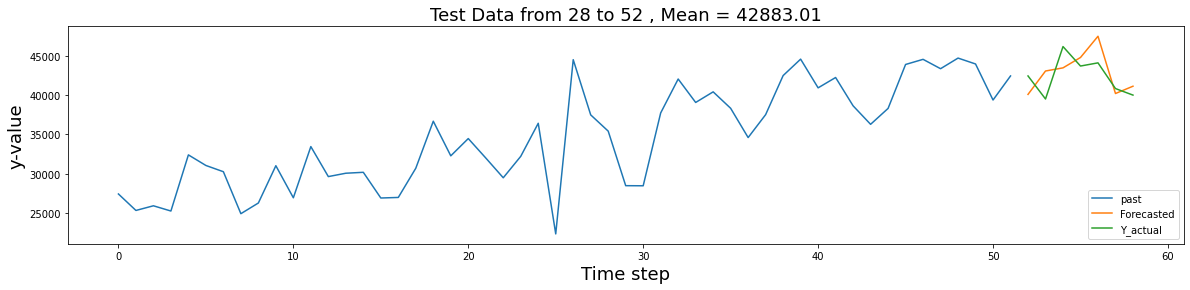

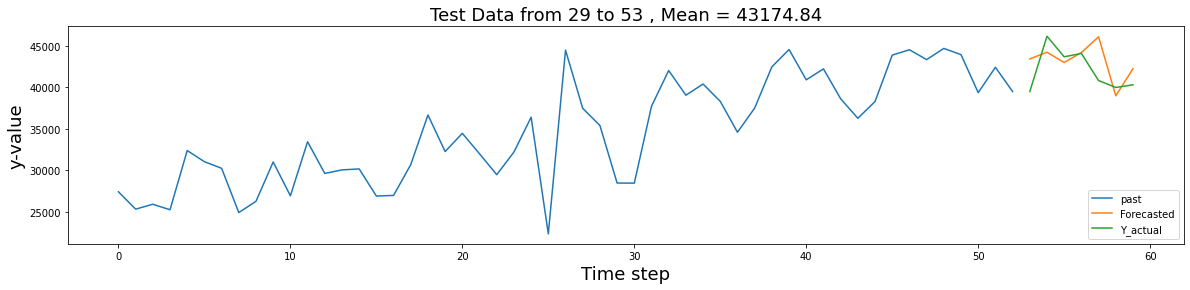

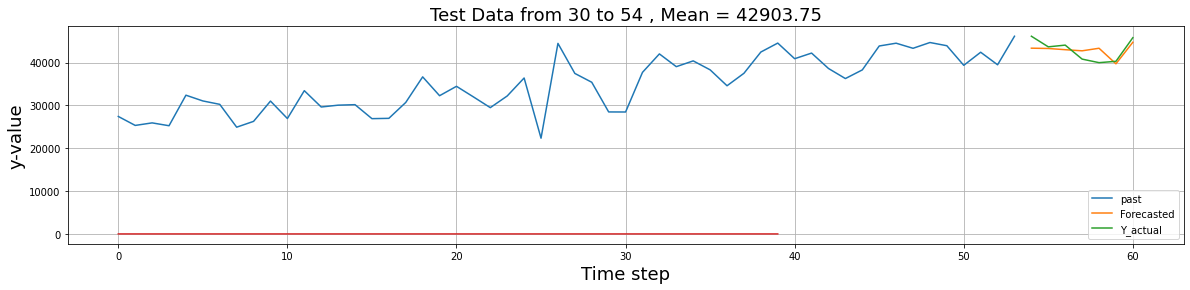

2022-06-14 20:44:51.877662: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Data from 0 to 28
Mean Absolute Error: 5189.71
Mean Absolute Percenatge Error: 16.31


Test Data from 1 to 29
Mean Absolute Error: 4523.59
Mean Absolute Percenatge Error: 14.38


Test Data from 2 to 30
Mean Absolute Error: 4621.06
Mean Absolute Percenatge Error: 14.62


Test Data from 3 to 31
Mean Absolute Error: 3723.31
Mean Absolute Percenatge Error: 11.18


Test Data from 4 to 32
Mean Absolute Error: 2655.81
Mean Absolute Percenatge Error: 7.08


Test Data from 5 to 33
Mean Absolute Error: 2374.41
Mean Absolute Percenatge Error: 6.26


Test Data from 6 to 34
Mean Absolute Error: 1773.57
Mean Absolute Percenatge Error: 4.65


Test Data from 7 to 35
Mean Absolute Error: 1867.57
Mean Absolute Percenatge Error: 4.68


Test Data from 8 to 36
Mean Absolute Error: 1741.96
Mean Absolute Percenatge Error: 4.46


Test Data from 9 to 37
Mean Absolute Error: 2420.06
Mean Absolute Percenatge Error: 6.15


Test Data from 10 to 38
Mean Absolute Error: 1663.52
Mean Absolute Percenatge Error: 4

 60%|███████████████████████▍               | 3/5 [2:32:05<1:41:23, 3041.73s/it]


IndexError: index 27 is out of bounds for axis 0 with size 27

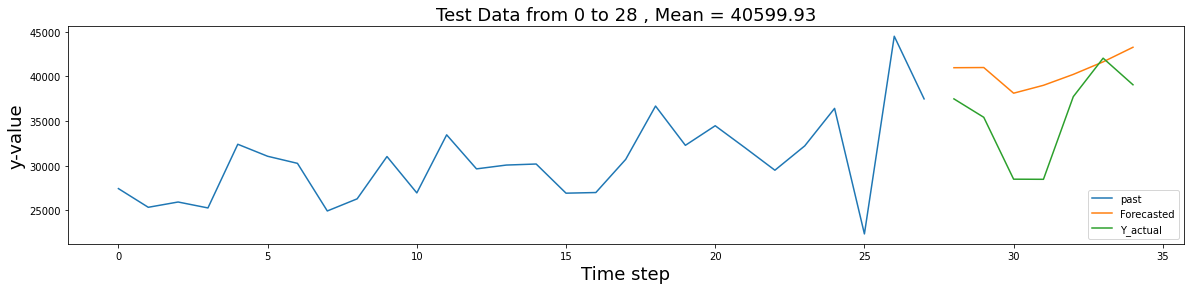

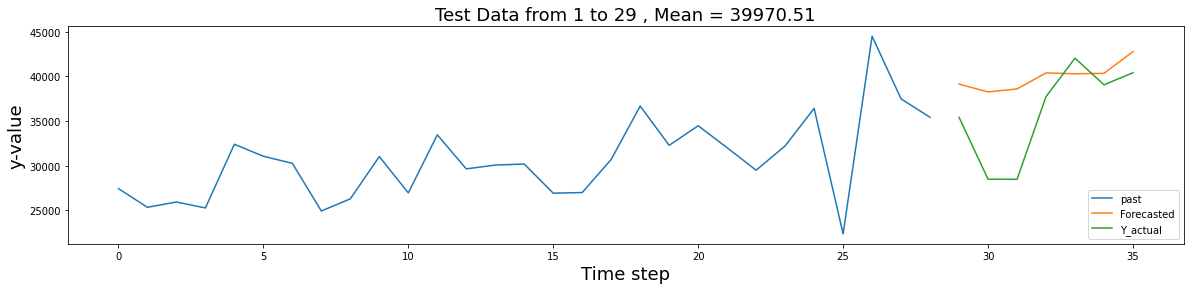

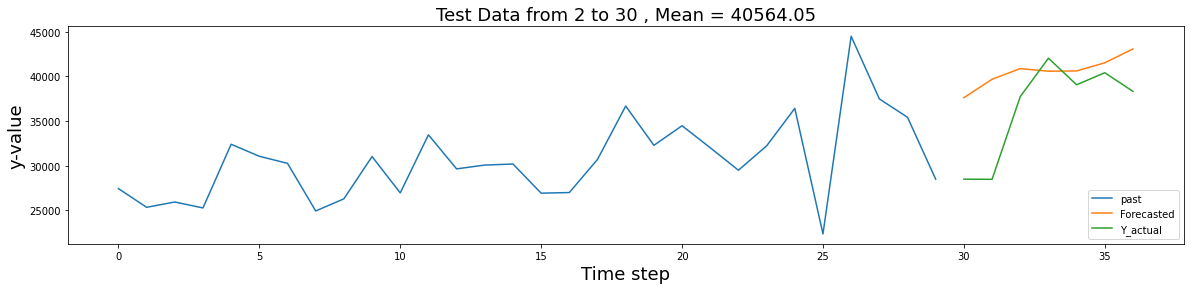

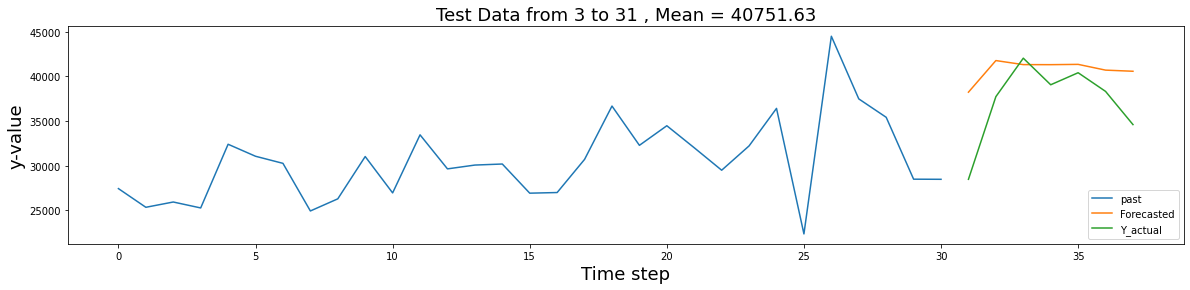

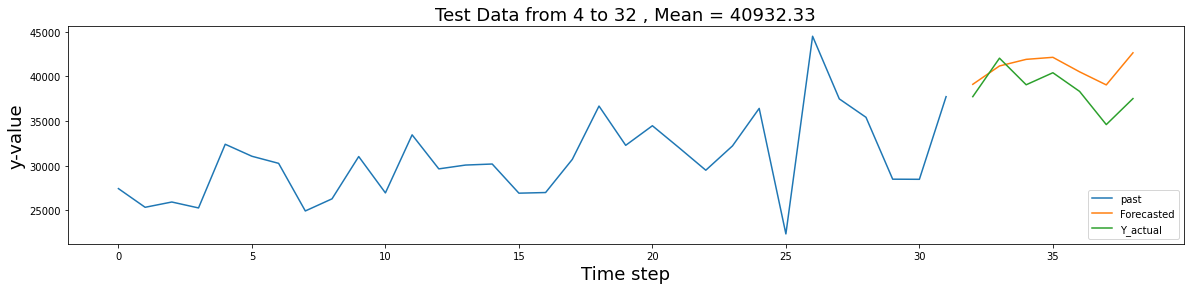

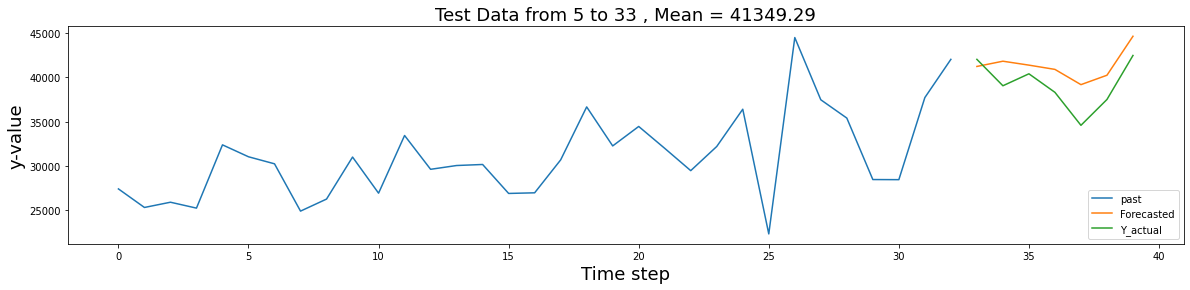

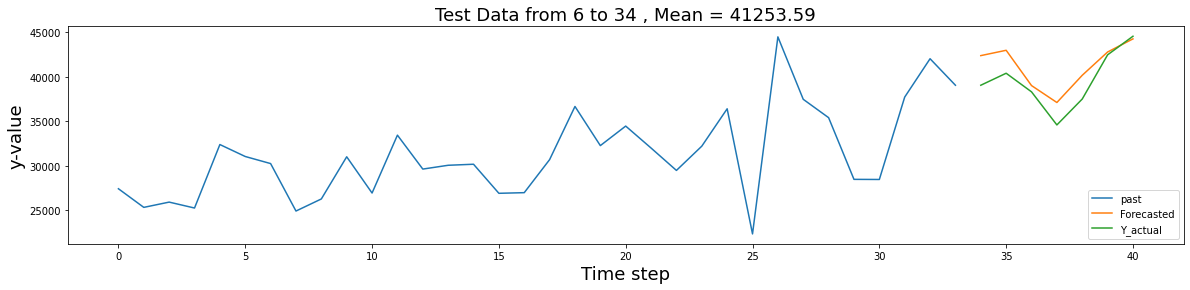

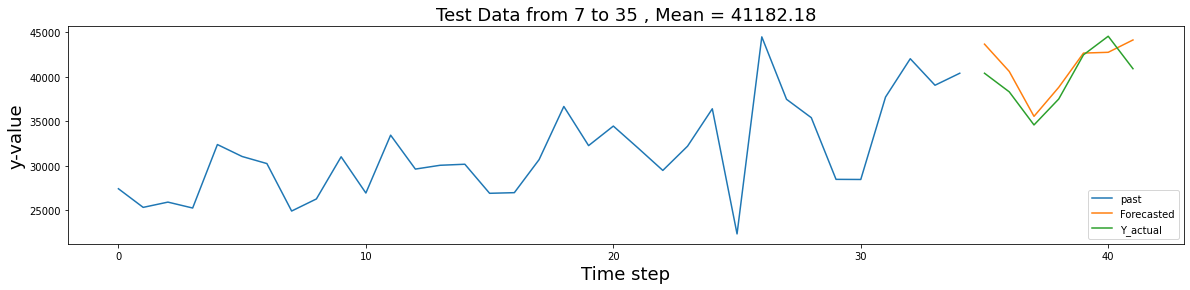

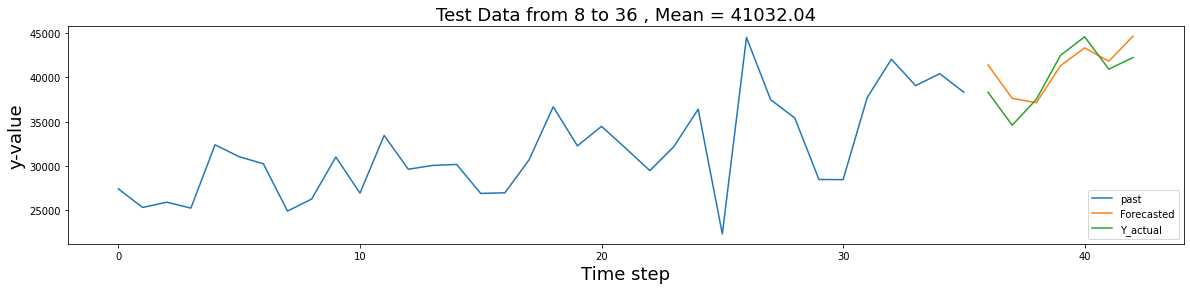

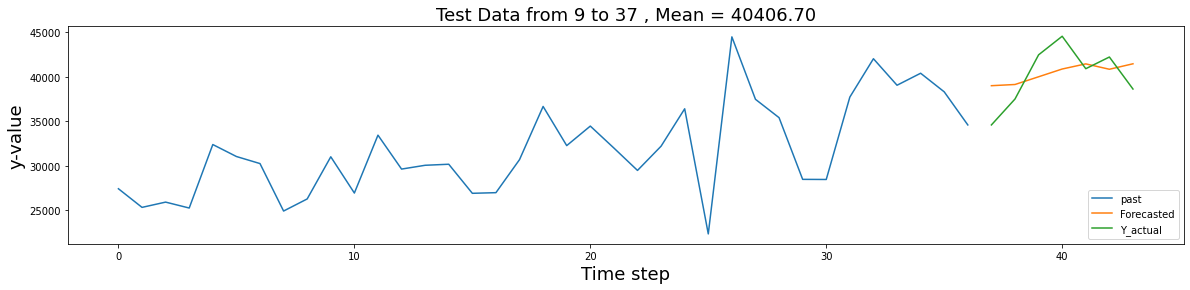

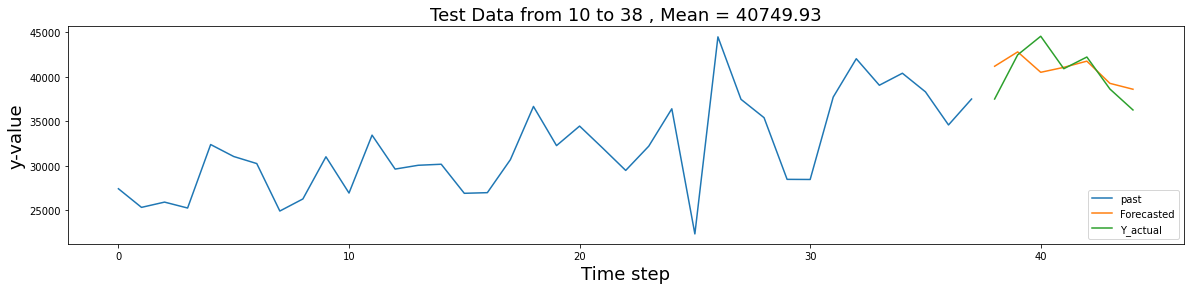

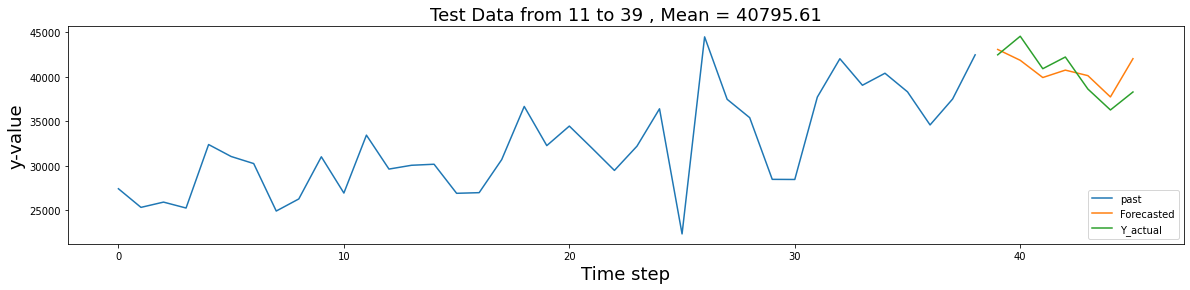

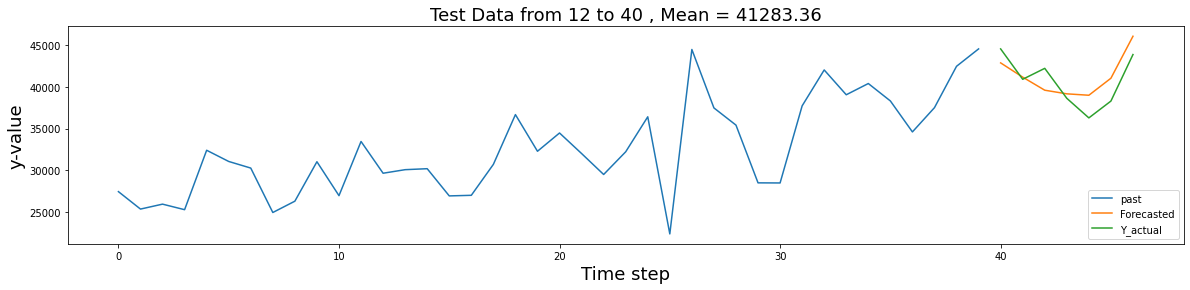

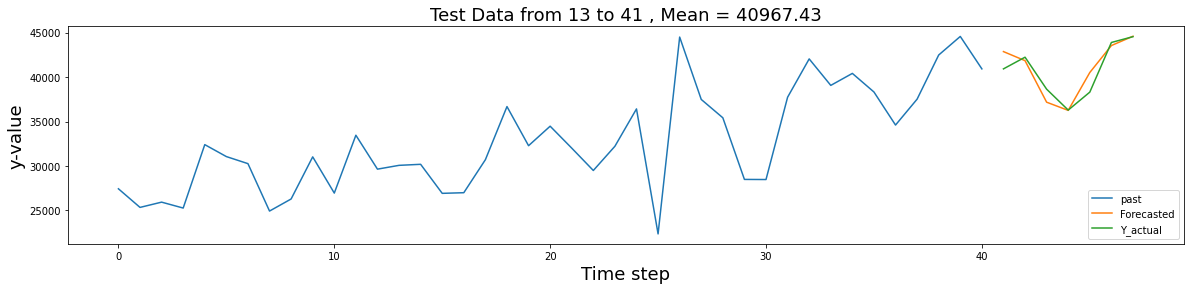

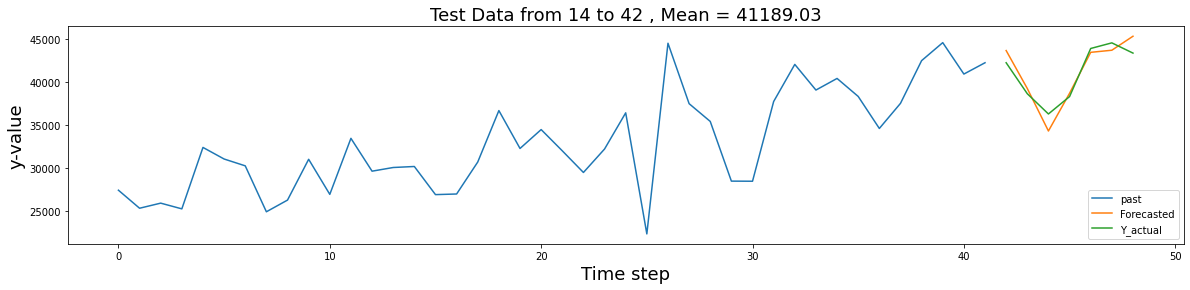

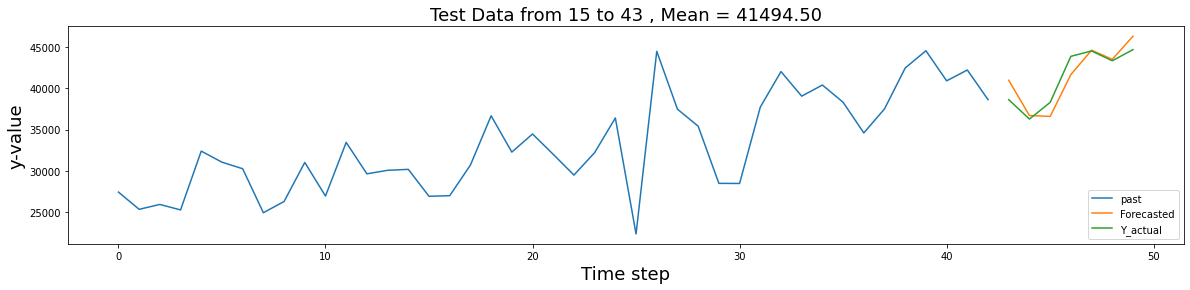

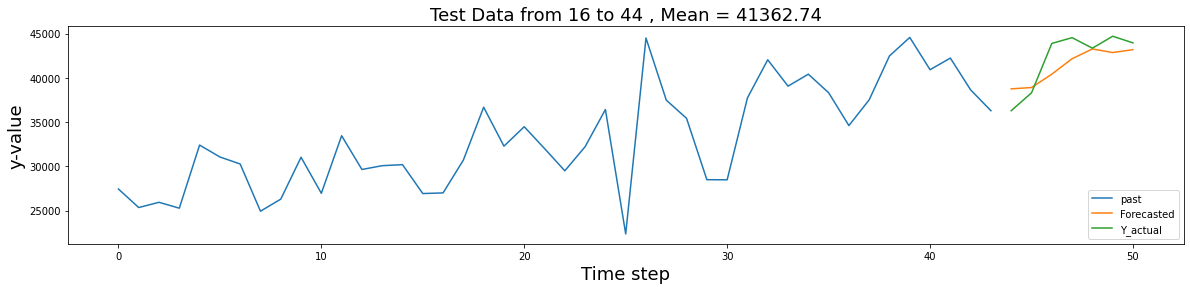

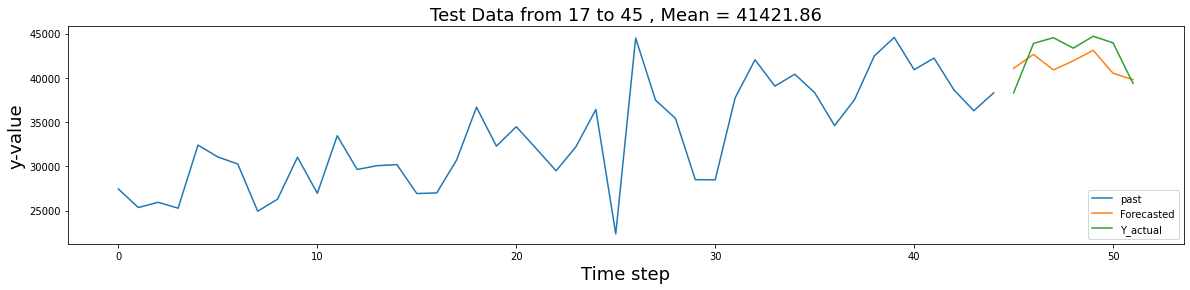

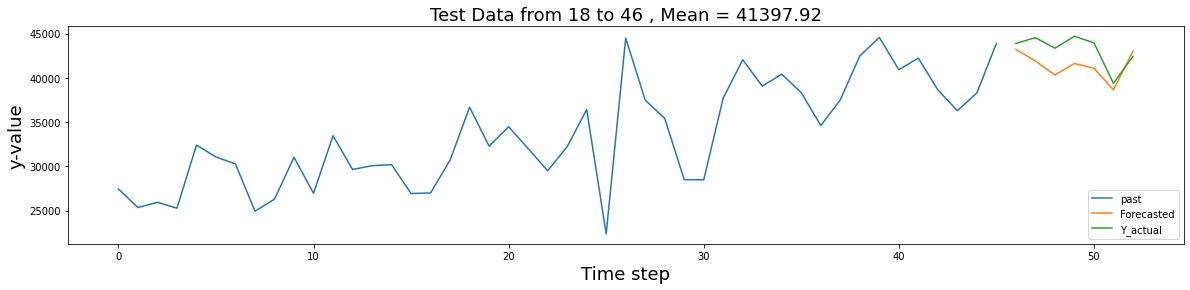

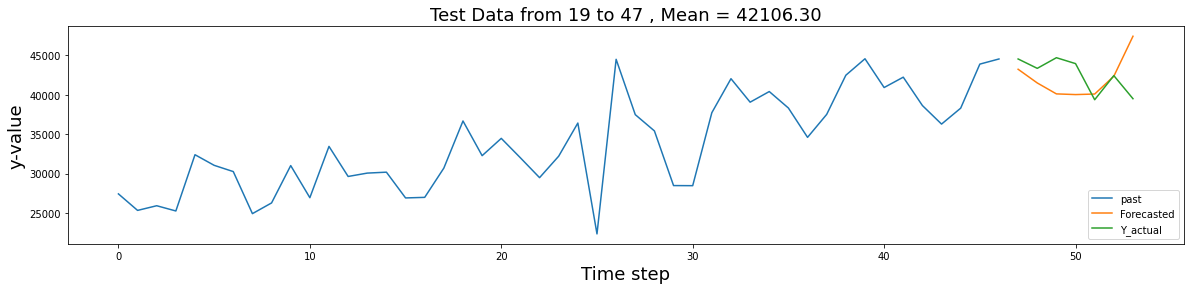

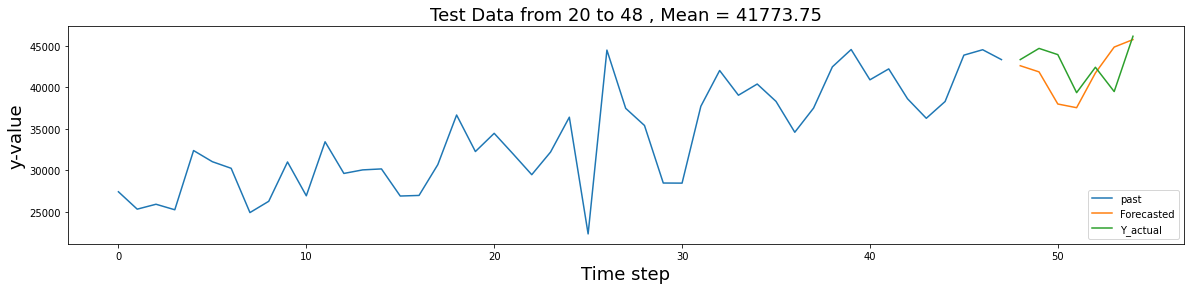

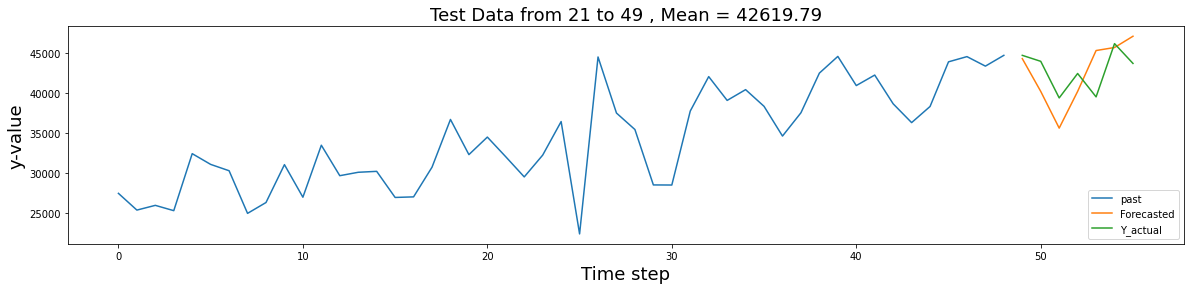

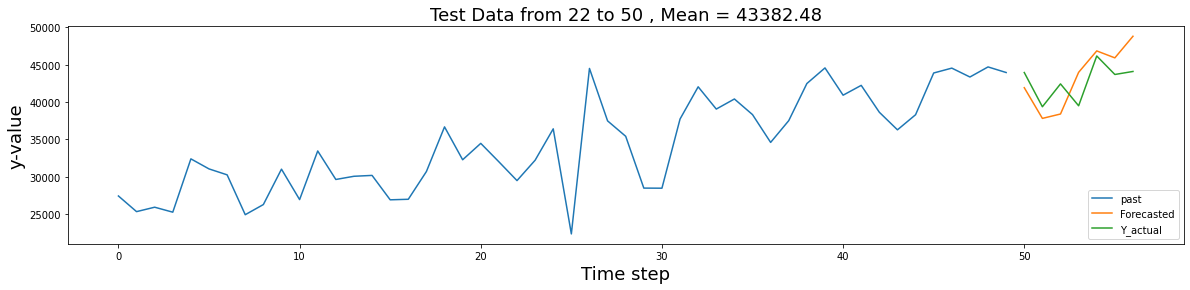

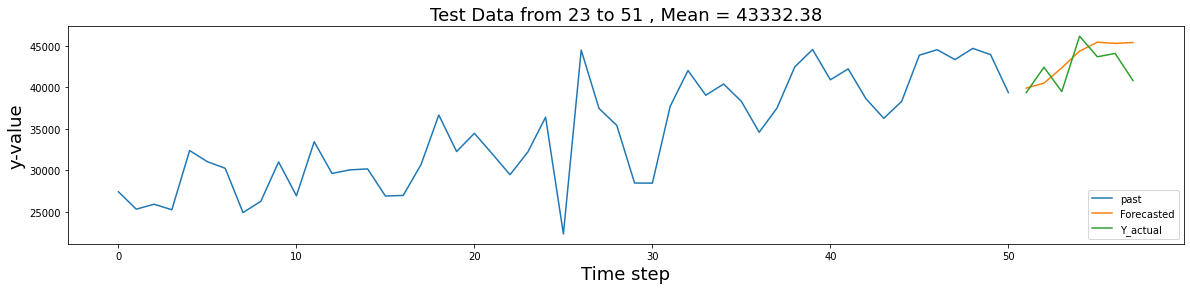

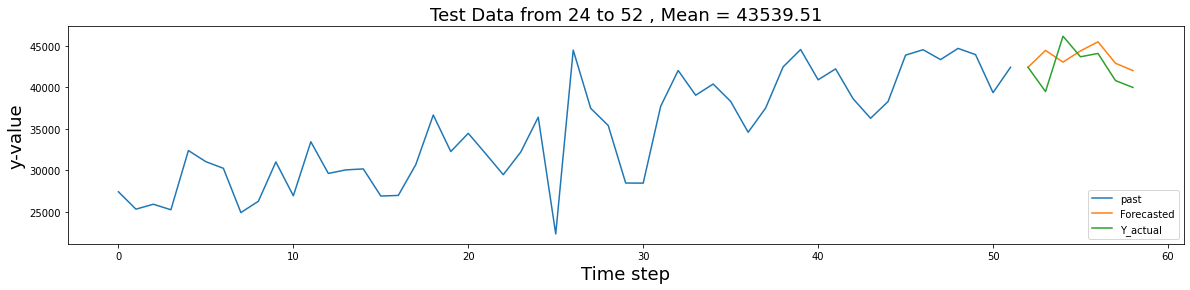

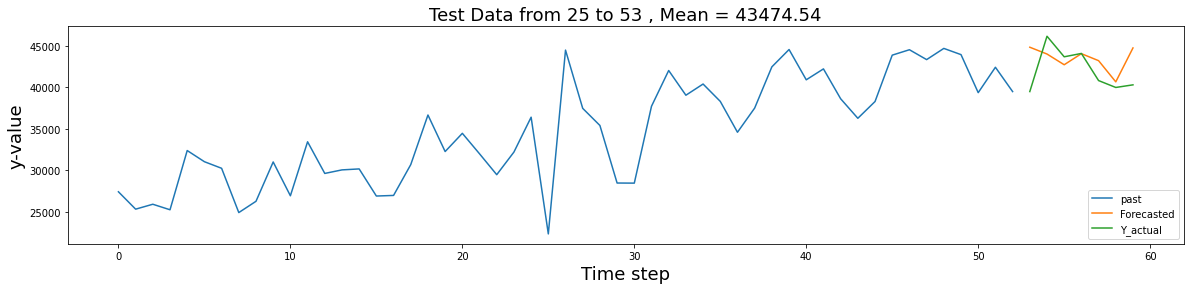

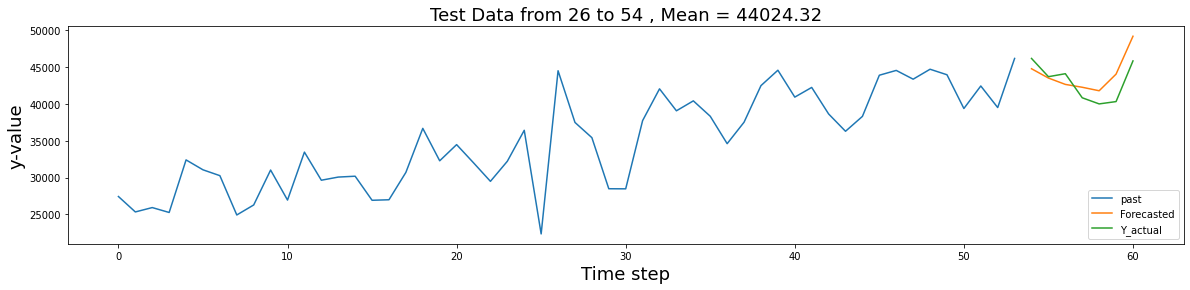

In [73]:
# Parameters
scaler_X_tr = preprocessing.MinMaxScaler()
scaler_Y_tr = preprocessing.MinMaxScaler()
batch_size = 32
#n_steps_in = 24
n_steps_out = 7
epoch = 40
verbose = 1
dropout_ratio = 0

# Feature Engineering
## Scaling
X_train_con = scaler_X_tr.fit_transform(X_train[continous_feature])
X_train_cat = X_train[category_feature].to_numpy()
X_train_gru = np.concatenate((X_train_con, X_train_cat), axis=1)
Y_train_gru = scaler_Y_tr.fit_transform(Y_train)

X_test_con = scaler_X_tr.transform(X_test[continous_feature])
X_test_cat = X_test[category_feature].to_numpy()
X_test_gru = np.concatenate((X_test_con, X_test_cat), axis=1)
Y_test_gru = scaler_Y_tr.transform(Y_test)

print('X_train_gru:', X_train_gru.shape, 'Y_train_gru:', Y_train_gru.shape)
print('X_test_gru:', X_test_gru.shape, 'Y_test_gru:', Y_test_gru.shape)

####################### iterations #######################
#Score = dict()
n_step_in_list = [i for i in range(16,33,4)]
for i in tqdm(n_step_in_list):
    n_steps_in = i
    
    ## X / Y Split
    X_train_multi_gru, Y_train_multi_gru = [], []
    for index in range(len(X_train_gru)):
        # find the end of this pattern
        end_ix = index + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(X_train_gru):
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = X_train_gru[index:end_ix, :], Y_train_gru[end_ix-1:out_end_ix, -1]
        X_train_multi_gru.append(seq_x)
        Y_train_multi_gru.append(seq_y)
    X_train_multi_gru, Y_train_multi_gru = np.array(X_train_multi_gru), np.array(Y_train_multi_gru) 
    print('X_train_multi_gru:', X_train_multi_gru.shape, 'Y_train_multi_gru:', Y_train_multi_gru.shape)


    X_test_multi_gru, Y_test_multi_gru = [], []
    for index in range(len(X_test_gru)):
        # find the end of this pattern
        end_ix = index + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        # check if we are beyond the dataset
        if out_end_ix > len(X_test_gru):
            break
        #gather input and output parts of the pattern
        seq_x, seq_y = X_test_gru[index:end_ix, :], Y_test_gru[end_ix-1:out_end_ix, -1]
        X_test_multi_gru.append(seq_x)
        Y_test_multi_gru.append(seq_y)
    X_test_multi_gru, Y_test_multi_gru = np.array(X_test_multi_gru), np.array(Y_test_multi_gru) 
    print('X_test_multi_gru:', X_test_multi_gru.shape, 'Y_test_multi_gru:', Y_test_multi_gru.shape)

    # GRU
    model = Sequential()
    model.add(GRU(128, input_shape=(X_train_multi_gru.shape[1], X_train_multi_gru.shape[2]), return_sequences=True, activation='relu'))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(256, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(128, return_sequences=True, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(GRU(64, return_sequences=False, activation="relu"))
    model.add(Dropout(dropout_ratio)) 
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    model_fit_multi_gru = model.fit(X_train_multi_gru, Y_train_multi_gru, 
                          batch_size=batch_size, epochs=epoch,
                          verbose=verbose)

    plt.plot(pd.DataFrame(model_fit_multi_gru.history))
    plt.grid(True)
    plt.show()

    # prediction
    Y_train_pred_multi_gru = model.predict(X_train_multi_gru)
    Y_test_pred_multi_gru = model.predict(X_test_multi_gru)

    if scaler_Y_tr != []:
        Y_train_multi_gru = scaler_Y_tr.inverse_transform(Y_train_multi_gru)
        Y_train_pred_multi_gru = scaler_Y_tr.inverse_transform(Y_train_pred_multi_gru)
        Y_test_multi_gru = scaler_Y_tr.inverse_transform(Y_test_multi_gru)
        Y_test_pred_multi_gru = scaler_Y_tr.inverse_transform(Y_test_pred_multi_gru)

    for i in range(0,31,1):
        start = i
        end = start + n_steps_in 
        last = end + n_steps_out 
        pred7, real7, past24 = prep_data(Y_test_gru, Y_test_pred_multi_gru, start, end, last) 
        evaluate_prediction(pred7, real7 , start , end) 
        plot_multistep(past24 , pred7 , real7 , start , end) 

In [75]:
#Y_test.to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test.csv')
#pd.DataFrame(scaler_Y_tr.inverse_transform(Y_test_gru)).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test_gru.csv')
#pd.DataFrame(Y_test_pred_multi_gru).to_csv('/Users/kimjinseok/Desktop/work/data_science/kaflix_demand forecasting/csv/gru_y_check/Y_test_pred_multi_gru.csv')

In [78]:
Y_test_gru

array([[0.55401394],
       [0.51174392],
       [0.52369989],
       [0.51026962],
       [0.65432697],
       [0.62718368],
       [0.61114814],
       [0.5034434 ],
       [0.53086943],
       [0.62653741],
       [0.54427951],
       [0.67563365],
       [0.59864687],
       [0.60727052],
       [0.60963344],
       [0.54367363],
       [0.54512774],
       [0.62011512],
       [0.74074523],
       [0.65190346],
       [0.69621327],
       [0.64638998],
       [0.59559729],
       [0.65063112],
       [0.7354539 ],
       [0.45151974],
       [0.89865697],
       [0.75696254],
       [0.71529839],
       [0.57532061],
       [0.57505806],
       [0.76201151],
       [0.84903565],
       [0.78889225],
       [0.81611633],
       [0.7739069 ],
       [0.69881854],
       [0.7576492 ],
       [0.85788145],
       [0.90007069],
       [0.82639604],
       [0.85293345],
       [0.7802888 ],
       [0.73278804],
       [0.77358376],
       [0.88637787],
       [0.89954559],
       [0.875